# <font color='brown'>Predicting whether a loan is Charged Off or not using Machine Learning</font>
### <center>(Group 1 )</center>


## 1) INTRODUCTION:

We’ll be working with some data from Lending Club, a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. Each borrower fills out a comprehensive application, providing (income, employment length, debt-to-income ratio, etc.) Lending Club evaluates each borrower’s FICO score(credit score) using past historical data (and their own data science process!) and assigns an interest rate to the borrower.

Approved loans are listed on the Lending Club website, where qualified investors can browse recently approved loans, the borrower’s credit score, the purpose for the loan, and other information from the application.

Once an investor decides to fund a loan, the borrower then makes monthly payments back to Lending Club. Lending Club redistributes these payments to investors. This means that investors don’t have to wait until the full amount is paid off to start to see returns. If a loan is fully paid off on time, the investors make a return which corresponds to the interest rate the borrower had to pay in addition to the requested amount.

Many loans aren’t completely paid off on time, however, and some borrowers default on the loan. That’s the problem we’ll be trying to address as we clean some data from Lending Club for machine learning. Let’s imagine we’ve been tasked with building a model to predict whether borrowers are likely to pay or default on their loans.

# 2. Importing Libraries and loading data:

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = [15, 8]


# for statistical testing:
import scipy.stats as stats

# for webscrapping:
import requests
from bs4 import BeautifulSoup


# for imputation:
from sklearn.impute import KNNImputer

# for model building:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# for model evaluation:
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, confusion_matrix, roc_curve, f1_score
from sklearn.model_selection import cross_val_predict

# to deal with the imbalance:
from imblearn.over_sampling import SMOTE

In [3]:
loan = pd.read_csv('accepted_2007_to_2018Q4.csv')
loan.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
259151,51156298,NaN,12800.0,12800.0,12800.0,60 months,13.99,297.77,C,C4,Director of Nursing,1 year,RENT,99840.0,Verified,Jun-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=51156298,NaN,other,Other,770xx,TX,21.48,0.0,Jan-2002,665.0,669.0,0.0,31.0,NaN,22.0,0.0,30411.0,99.1,44.0,w,0.0,0.0,15346.584689,15346.58,12800.00,2546.58,0.0,0.0,0.0,Feb-2017,87.03,NaN,Aug-2018,719.0,715.0,0.0,31.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,193392.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30700.0,NaN,NaN,NaN,0.0,8791.0,0.0,100.1,0.0,0.0,160.0,126.0,54.0,49.0,2.0,89.0,NaN,NaN,NaN,1.0,4.0,8.0,4.0,6.0,28.0,8.0,12.0,8.0,22.0,0.0,0.0,0.0,0.0,95.1,100.0,0.0,0.0,204947.0,193392.0,21600.0,174247.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1685129,97983864,NaN,20000.0,20000.0,19950.0,36 months,11.39,658.48,B,B3,OR tech,10+ years,MORTGAGE,75000.0,Not Verified,Mar-2017,Charged Off,n,https://lendingclub.com/browse/loanDetail.action?loan_id=97983864,NaN,debt_consolidation,Debt consolidation,117xx,NY,12.43,0.0,Mar-2001,665.0,669.0,1.0,NaN,70.0,5.0,1.0,13239.0,64.9,12.0,f,0.0,0.0,8656.050000,8634.41,6451.75,2129.30,0.0,75.0,13.5,Apr-2018,658.48,NaN,Mar-2019,549.0,545.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,15662.0,0.0,1.0,0.0,0.0,31.0,2423.0,25.0,0.0,0.0,4723.0,52.0,20400.0,0.0,2.0,1.0,0.0,3132.0,7161.0,64.9,0.0,0.0,117.0,186.0,41.0,31.0,1.0,41.0,NaN,1.0,NaN,0.0,4.0,4.0,4.0,5.0,3.0,4.0,7.0,4.0,5.0,0.0,0.0,0.0,0.0,100.0,75.0,1.0,0.0,30000.0,15662.0,20400.0

* Checking basic details of the data:

In [4]:
loan.shape

(2260701, 151)

# 3. TARGET:

Our goal is to predict if the applicant is going to default or not.

In [5]:
# checking target variable:
loan['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

We only want Fully Paid and Charged off, as fully paid means not default and charged off means default.

Creating new dataframe for these **Charged Off** and **Fully Paid** categories.

In [6]:
loan1 = loan[(loan['loan_status']=="Fully Paid") | (loan['loan_status']=="Charged Off")]

Let's check how how many rows and columns we have in these new dataframe.

In [7]:
loan1.shape

(1345310, 151)

In [8]:
loan1['loan_status'].value_counts()

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

## 3.1 The approach we're going for is first we'll train the data on the latest data.

* The fiscal year in USA is 1st October to 31st September.
* So on the basis of issue_d, we'll take a sample for last 3 quarters, out of those three quarters we'll train the data on first 2 quarters and test it on the 3rd quarter. 

In [9]:
loan1['issue_d'].head()

0    Dec-2015
1    Dec-2015
2    Dec-2015
4    Dec-2015
5    Dec-2015
Name: issue_d, dtype: object

It is a object so first we'll convert into date time. 

In [10]:
loan1['issue_d'] = pd.to_datetime(loan1['issue_d'], format= '%b-%Y')

In [11]:
loan1['issue_d'].max()

Timestamp('2018-12-01 00:00:00')

We have data available till December 2018.
So we'll take 2017-18 fiscal year.
So we'll take a sample data of 1st January 2018 to 31st September 2018, which comprises of last 3 quarters of financial year 2017-18.

In [12]:
loan2 = loan1[(loan1["issue_d"] >= '2018-01-01') & (loan1["issue_d"] <= '2018-09-30')]

In [13]:
loan2.shape

(51281, 151)

# 4. LIMITING THE FEATURE SPACE:
* We'll see if we can eliminate some columns before diving into further analysis.

In [14]:
loan2.isnull().sum()/loan2.shape[0] * 100

id                                              0.000000
member_id                                     100.000000
loan_amnt                                       0.000000
funded_amnt                                     0.000000
funded_amnt_inv                                 0.000000
term                                            0.000000
int_rate                                        0.000000
installment                                     0.000000
grade                                           0.000000
sub_grade                                       0.000000
emp_title                                       9.172988
emp_length                                      8.751779
home_ownership                                  0.000000
annual_inc                                      0.000000
verification_status                             0.000000
issue_d                                         0.000000
loan_status                                     0.000000
pymnt_plan                     

We can see there are some variables which are having more than 50% missing values.
We'll first remove those columns which have more than 50% missing values

## 4.1 Dropping features with more than 50% missing values.

In [15]:
df = loan2[loan2.columns[loan2.isnull().sum()/loan2.shape[0]<0.50]]

In [16]:
df.shape

(51281, 107)

Checking latest available data.

In [17]:
df.head(5)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
421101,130956066,3000.0,3000.0,3000.0,36 months,7.34,93.10,A,A4,Scale Technician,9 years,RENT,52000.0,Source Verified,2018-03-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=130956066,major_purchase,Major purchase,988xx,WA,0.58,0.0,Jan-1998,760.0,764.0,0.0,7.0,0.0,141.0,0.5,30.0,w,0.0,0.0,3011.577285,3011.58,3000.0,11.58,0.0,0.0,0.0,May-2018,614.03,Nov-2018,764.0,760.0,0.0,1.0,Individual,0.0,0.0,150592.0,0.0,0.0,1.0,2.0,7.0,0.0,NaN,0.0,1.0,141.0,1.0,31000.0,1.0,2.0,2.0,3.0,25099.0,30359.0,0.5,0.0,0.0,132.0,242.0,18.0,7.0,4.0,18.0,7.0,0.0,1.0,1.0,4.0,15.0,7.0,6.0,19.0,1.0,7.0,0.0,0.0,0.0,1.0,96.7,0.0,0.0,0.0,191216.0,141.0,30500.0,0.0,N,Cash,N
421113,130968727,5000.0,5000.0,5000.0,36 months,11.98,166.03,B,B5,SDO Supervisor,10+ years,OWN,55000.0,Not Verified,2018-03-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=130968727,other,Other,300xx,GA,14.18,0.0,Aug-2001,675.0,679.0,0.0,14.0,1.0,11449.0,33.9,24.0,w,0.0,0.0,5013.306667,5013.31,5000.0,13.31,0.0,0.0,0.0,Apr-2018,5019.97,Aug-2018,679.0,675.0,0.0,1.0,Individual,0.0,0.0,28880.0,1.0,1.0,0.0,0.0,33.0,17431.0,63.0,2.0,2.0,4829.0,47.0,33800.0,0.0,1.0,1.0,2.0,2222.0,10551.0,52.0,0.0,0.0,77.0,199.0,3.0,3.0,0.0,3.0,12.0,1.0,3.0,3.0,4.0,7.0,6.0,13.0,18.0,3.0,14.0,0.0,0.0,0.0,2.0,95.7,33.3,1.0,0.0,61551.0,28880.0,22000.0,27751.0,N,Cash,N
421120,130910225,7000.0,7000.0,7000.0,36 months,11.98,232.44,B,B5,Parole,< 1 year,MORTGAGE,40000.0,Verified,2018-03-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=130910225,home_improvement,Home improvement,797xx,TX,20.25,0.0,Mar-2007,695.0,699.0,0.0,13.0,0.0,5004.0,36.0,29.0,w,0.0,0.0,7693.314943,7693.31,7000.0,693.31,0.0,0.0,0.0,Mar-2019,5364.25,Mar-2019,644.0,640.0,0.0,1.0,Individual,0.0,0.0,131726.0,1.0,6.0,0.0,2.0,16.0,126722.0,102.0,2.0,2.0,3944.0,90.0,13900.0,2.0,1.0,4.0,4.0,10977.0,4996.0,50.0,0.0,0.0,122.0,132.0,1.0,1.0,0.0,10.0,5.0,3.0,2.0,2.0,3.0,4.0,19.0,7.0,10.0,2.0,13.0,0.0,0.0,0.0,2.0,89.7,33.3,0.0,0.0,132817.0,131726.0,10000.0,118917.0,N,Cash,N
421135,130966492,30000.0,30000.0,30000.0,36 months,21.85,1143.39,D,D5,teacher,10+ years,OWN,57000.0,Verified,2018-03-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=130966492,debt_consolidation,Debt consolidation,341xx,FL,27.58,0.0,Apr-2000,680.0,684.0,1.0,11.0,0.0,29222.0,53.2,26.0,w,0.0,0.0,34389.550341,34389.55,30000.0,4389.55,0.0,0.0,0.0,Dec-2018,26458.65,Dec-2018,699.0,695.0,0.0,1.0,Individual,0.0,0.0,157566.0,1.0,1.0,2.0,2.0,

In [18]:
df.reset_index(drop = True, inplace = True)

In [19]:
df.head(5)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,130956066,3000.0,3000.0,3000.0,36 months,7.34,93.10,A,A4,Scale Technician,9 years,RENT,52000.0,Source Verified,2018-03-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=130956066,major_purchase,Major purchase,988xx,WA,0.58,0.0,Jan-1998,760.0,764.0,0.0,7.0,0.0,141.0,0.5,30.0,w,0.0,0.0,3011.577285,3011.58,3000.0,11.58,0.0,0.0,0.0,May-2018,614.03,Nov-2018,764.0,760.0,0.0,1.0,Individual,0.0,0.0,150592.0,0.0,0.0,1.0,2.0,7.0,0.0,NaN,0.0,1.0,141.0,1.0,31000.0,1.0,2.0,2.0,3.0,25099.0,30359.0,0.5,0.0,0.0,132.0,242.0,18.0,7.0,4.0,18.0,7.0,0.0,1.0,1.0,4.0,15.0,7.0,6.0,19.0,1.0,7.0,0.0,0.0,0.0,1.0,96.7,0.0,0.0,0.0,191216.0,141.0,30500.0,0.0,N,Cash,N
1,130968727,5000.0,5000.0,5000.0,36 months,11.98,166.03,B,B5,SDO Supervisor,10+ years,OWN,55000.0,Not Verified,2018-03-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=130968727,other,Other,300xx,GA,14.18,0.0,Aug-2001,675.0,679.0,0.0,14.0,1.0,11449.0,33.9,24.0,w,0.0,0.0,5013.306667,5013.31,5000.0,13.31,0.0,0.0,0.0,Apr-2018,5019.97,Aug-2018,679.0,675.0,0.0,1.0,Individual,0.0,0.0,28880.0,1.0,1.0,0.0,0.0,33.0,17431.0,63.0,2.0,2.0,4829.0,47.0,33800.0,0.0,1.0,1.0,2.0,2222.0,10551.0,52.0,0.0,0.0,77.0,199.0,3.0,3.0,0.0,3.0,12.0,1.0,3.0,3.0,4.0,7.0,6.0,13.0,18.0,3.0,14.0,0.0,0.0,0.0,2.0,95.7,33.3,1.0,0.0,61551.0,28880.0,22000.0,27751.0,N,Cash,N
2,130910225,7000.0,7000.0,7000.0,36 months,11.98,232.44,B,B5,Parole,< 1 year,MORTGAGE,40000.0,Verified,2018-03-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=130910225,home_improvement,Home improvement,797xx,TX,20.25,0.0,Mar-2007,695.0,699.0,0.0,13.0,0.0,5004.0,36.0,29.0,w,0.0,0.0,7693.314943,7693.31,7000.0,693.31,0.0,0.0,0.0,Mar-2019,5364.25,Mar-2019,644.0,640.0,0.0,1.0,Individual,0.0,0.0,131726.0,1.0,6.0,0.0,2.0,16.0,126722.0,102.0,2.0,2.0,3944.0,90.0,13900.0,2.0,1.0,4.0,4.0,10977.0,4996.0,50.0,0.0,0.0,122.0,132.0,1.0,1.0,0.0,10.0,5.0,3.0,2.0,2.0,3.0,4.0,19.0,7.0,10.0,2.0,13.0,0.0,0.0,0.0,2.0,89.7,33.3,0.0,0.0,132817.0,131726.0,10000.0,118917.0,N,Cash,N
3,130966492,30000.0,30000.0,30000.0,36 months,21.85,1143.39,D,D5,teacher,10+ years,OWN,57000.0,Verified,2018-03-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=130966492,debt_consolidation,Debt consolidation,341xx,FL,27.58,0.0,Apr-2000,680.0,684.0,1.0,11.0,0.0,29222.0,53.2,26.0,w,0.0,0.0,34389.550341,34389.55,30000.0,4389.55,0.0,0.0,0.0,Dec-2018,26458.65,Dec-2018,699.0,695.0,0.0,1.0,Individual,0.0,0.0,157566.0,1.0,1.0,2.0,2.0,6.0,33030.0,94.0,2.0

## 4.2 Deciding which columns to Keep:
* Here we are going to keep only those features that would have been available during the application by potential customer. These features are like Annual Income, loan_amount, employment_title, grade etc.
* As based on this features only we're going to predict if that particular customer is going to default or not.
* After studying the data description, we are going to determine which features to keep.

In [20]:
kp_lst = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code', 'total_rev_hi_lim', 'total_bc_limit',
       'mths_since_rcnt_il', 'mort_acc', 'num_actv_bc_tl', 'il_util']

In [21]:
# making sure there are no duplicates in the keep list
kp_lst = list(set(kp_lst))

In [22]:
df1 = df.loc[:, kp_lst]

In [23]:
df1.head()

,title,addr_state,fico_range_high,int_rate,fico_range_low,zip_code,term,dti,emp_length,earliest_cr_line,home_ownership,issue_d,il_util,verification_status,annual_inc,emp_title,grade,pub_rec,total_bc_limit,installment,initial_list_status,open_acc,application_type,purpose,loan_status,total_rev_hi_lim,id,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,revol_util,sub_grade,mths_since_rcnt_il,mort_acc,total_acc,revol_bal
0,Major purchase,WA,764.0,7.34,760.0,988xx,36 months,0.58,9 years,Jan-1998,RENT,2018-03-01,NaN,Source Verified,52000.0,Scale Technician,A,0.0,30500.0,93.10,w,7.0,Individual,major_purchase,Fully Paid,31000.0,130956066,3000.0,1.0,0.0,0.5,A4,7.0,4.0,30.0,141.0
1,Other,GA,679.0,11.98,675.0,300xx,36 months,14.18,10+ years,Aug-2001,OWN,2018-03-01,63.0,Not Verified,55000.0,SDO Supervisor,B,1.0,22000.0,166.03,w,14.0,Individual,other,Fully Paid,33800.0,130968727,5000.0,3.0,1.0,33.9,B5,33.0,0.0,24.0,11449.0
2,Home improvement,TX,699.0,11.98,695.0,797xx,36 months,20.25,< 1 year,Mar-2007,MORTGAGE,2018-03-01,102.0,Verified,40000.0,Parole,B,0.0,10000.0,232.44,w,13.0,Individual,home_improvement,Fully Paid,13900.0,130910225,7000.0,2.0,0.0,36.0,B5,16.0,0.0,29.0,5004.0
3,Debt consolidation,FL,684.0,21.85,680.0,341xx,36 months,27.58,10+ years,Apr-2000,OWN,2018-03-01,94.0,Verified,57000.0,teacher,D,0.0,29400.0,1143.39,w,11.0,Individual,debt_consolidation,Fully Paid,55500.0,130966492,30000.0,3.0,0.0,53.2,D5,6.0,2.0,26.0,29222.0
4,Home buying,NY,669.0,20.39,665.0,135xx,60 months,15.76,10+ years,Nov-2008,OWN,2018-03-01,NaN,Source Verified,85000.0,Machine operator,D,0.0,27100.0,560.94,w,15.0,Individual,house,Fully Paid,42700.0,130942737,21000.0,5.0,0.0,34.2,D4,7.0,3.0,27.0,14591.0


# 5. EDA and Preprocessing:
* With visualization we'll also do some statistical testing to check if variable has any effect on our target variable.
* Anova to check if numercal column has any effect on the target.
* Chi2 to check if target has any dependency on categorical column.

## Creating Function to plot categorical and Numerical features:

In [24]:
# for cat_columns:
def plot_cat(col_name, full_name):
    
    #plotting only column:
    plt.figure(figsize = (12, 3))
    plt.subplot(1, 2, 1)
    sns.countplot(df1[col_name], order = sorted(df1[col_name].unique()), color = 'LightSteelBlue')
    plt.title(full_name)
    plt.xlabel(full_name)
    plt.xticks(rotation = 90)
    plt.ylabel('Count')
    
    # plotting vs. target column:
    plt.subplot(1, 2, 2)
    charge_off_rates = df1.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
    sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='CornflowerBlue')
    plt.title("Charge-of Rate by {}".format(full_name))
    plt.xlabel(full_name)
    plt.xticks(rotation = 90)
    plt.ylabel('Fraction of Loans Charged-off')
    

In [25]:
def plot_num(col_name, full_name):
    
    # plotting only column:
    plt.figure(figsize = (12, 3))
    plt.subplot(1, 2, 1)
    plt.hist(df1[col_name])
    plt.title(full_name)
    
    # plotting vs. target column:
    plt.subplot(1, 2, 2)
    sns.boxplot(x=col_name, y='loan_status', data=df1)
    plt.ylabel('')
    plt.title('{} by Loan Status'.format(full_name))

In [26]:
drop_lst = []

In [27]:
df1['loan_status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

## Creating function for ANOVA and Chi2 test: 

In [28]:
# for ANOVA:
def anova_(col_name, full_name):
    print("Stating Hypothesis:")
    print("H0: {} has no effect on loan status".format(full_name))
    print("H1: {} has some effect on loan status".format(full_name))
    
    print()
    # creating data for one way anova:
    d1 = df1[df1['loan_status'] == 'Fully Paid'][col_name]
    d2 = df1[df1['loan_status'] == 'Charged Off'][col_name]
    test_stat, pvalue = stats.f_oneway(d1, d2)
    print("Pvalue = ", pvalue)
    
    if pvalue>0.05:
        print("Fail to reject Null hypothesis, {} has no effect on loan status.".format(full_name))
    else:
        print("Reject Null hypothesis, {} has some effect on loan status.".format(full_name))

In [29]:
# for chi2:
def chi2_(col_name, full_name):
    print("Stating Hypothesis:")
    print("H0: {} has no effect on loan status".format(full_name))
    print("H1: {} has some effect on loan status".format(full_name))
    
    print()
    
    d = pd.crosstab(df1['loan_status'], df1[col_name])
    test_stat, pvalue, dof, exp_freq = stats.chi2_contingency(d)
    print("Pvalue = ", pvalue)
    
    if pvalue>0.05:
        print("Fail to reject Null hypothesis, {} has no effect on loan status.".format(full_name))
    else:
        print("Reject Null hypothesis, {} has some effect on loan status.".format(full_name))    
    

## addr_state:

In [30]:
df1['addr_state'].unique()

array(['WA', 'GA', 'TX', 'FL', 'NY', 'NJ', 'CA', 'IN', 'NV', 'MO', 'MI',
       'UT', 'PA', 'AZ', 'MS', 'MN', 'MD', 'CT', 'CO', 'NC', 'WI', 'ID',
       'IL', 'OH', 'HI', 'KS', 'OR', 'DE', 'NE', 'VA', 'KY', 'VT', 'LA',
       'WV', 'MA', 'AR', 'TN', 'NM', 'AL', 'OK', 'SC', 'SD', 'AK', 'NH',
       'ND', 'DC', 'ME', 'RI', 'WY', 'MT'], dtype=object)

In [31]:
df1.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()*100

addr_state
ME     4.794521
UT     8.764940
ID     9.051724
VT     9.345794
WV     9.836066
DC    10.576923
WY    10.638298
OR    11.040000
WA    11.194030
ND    11.650485
CT    12.238806
MT    12.258065
RI    12.946429
CO    13.066073
VA    13.622975
SC    13.922156
IL    14.336493
NH    14.473684
OH    14.594595
AK    15.116279
MN    15.271493
KS    15.297450
TN    15.375154
AZ    15.401302
KY    15.686275
IN    16.106605
NJ    16.562108
TX    17.024320
CA    17.262063
MI    17.496340
GA    17.687075
PA    17.816813
MA    17.927632
NM    18.217054
MD    18.533441
NV    18.541033
AL    18.677686
DE    19.078947
OK    19.135802
NC    19.294744
FL    19.720812
LA    20.116054
MO    20.175439
WI    21.491228
MS    21.710526
NY    21.879124
AR    22.255193
HI    22.272727
SD    23.300971
NE    23.412698
Name: loan_status, dtype: float64

* The Charge off ranges from 4.79% to 23.41%.
* NE is having large %tage of charge off.

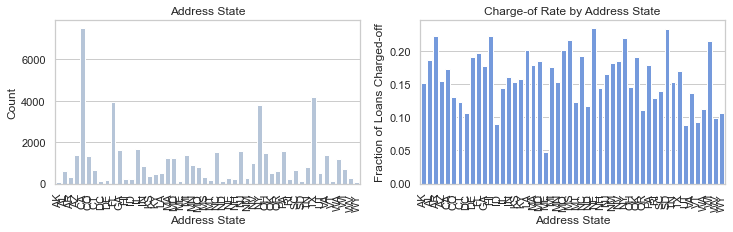

In [32]:
plot_cat('addr_state', 'Address State')

In [33]:
# checking statistically:
chi2_('addr_state', 'Address State')

Stating Hypothesis:
H0: Address State has no effect on loan status
H1: Address State has some effect on loan status

Pvalue =  3.1713616416954668e-43
Reject Null hypothesis, Address State has some effect on loan status.


In [34]:
df1['addr_state'].nunique()

50

* As we can see there are 50 unique values in address state, so let's divide them into regions using Standard Fedaral Regions.
* This is done with the help of following links:
    * Wiki: https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States
    * Usps: https://pe.usps.com/text/pub28/28apb.htm
 

In [35]:
url = 'https://pe.usps.com/text/pub28/28apb.htm'
head = {'User-Agent' : 'Mozilla/5.0'}
response = requests.get(url, headers = head )

In [36]:
soup = BeautifulSoup(response.content)
t = soup.find(class_ = 'Basic_no_title')
a = t.find_all('tr')
state = []
abb = []
for i in range(1, len(a)):
    st = a[i].find_all('td')[0].text.strip()
    ab = a[i].find_all('td')[1].text.strip()
    state.append(st)
    abb.append(ab)

In [37]:
region_ = pd.DataFrame({'State': state, 'abb': abb})

In [38]:
def reg(x):
    if x in 'Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, Vermont'.split(', '):
        return 'Region 1'
    elif x in 'New Jersey, New York, Puerto Rico, US Virgin Islands'.split(', '):
        return 'Region 2'
    elif x in 'Delaware, District of Columbia, Maryland, Pennsylvania, Virginia, West Virginia'.split(', '):
        return 'Region 3'
    elif x in 'Alabama, Florida, Georgia, Kentucky, Mississippi, North Carolina, South Carolina, Tennessee'.split(', '):
        return 'Region 4'
    elif x in 'Illinois, Indiana, Michigan, Minnesota, Ohio, Wisconsin'.split(', '):
        return 'Region 5'
    elif x in 'Arkansas, Louisiana, New Mexico, Oklahoma, Texas'.split(', '):
        return 'Region 6'
    elif x in 'Iowa, Kansas, Missouri, Nebraska'.split(', '):
        return 'Region 7'
    elif x in 'Colorado, Montana, North Dakota, South Dakota, Utah, Wyoming'.split(', '):
        return 'Region 8'
    elif x in 'Arizona, California, Hawaii, Nevada, American Samoa, Guam, Northern Mariana Islands'.split(', '):
        return 'Region 9'
    else:
        return 'Region 10'

In [39]:
region_['Region'] = region_['State'].apply(reg)

In [40]:
df1['add_region'] = df1['addr_state'].map(dict(zip(region_['abb'], region_['Region'])))

In [41]:
df1.groupby('add_region')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()*100

add_region
Region 10    11.074919
Region 8     12.369792
Region 1     14.627557
Region 5     16.051687
Region 3     16.258257
Region 9     17.241379
Region 6     17.834945
Region 4     18.387325
Region 7     19.529579
Region 2     20.304663
Name: loan_status, dtype: float64

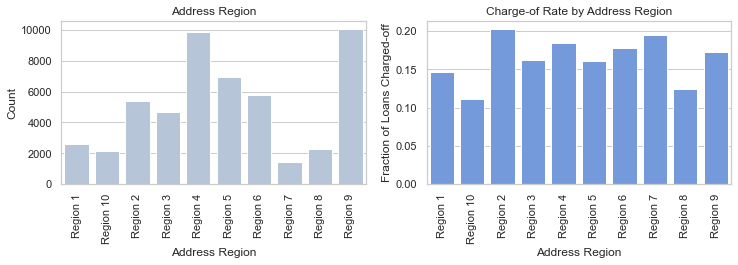

In [42]:
plot_cat('add_region', 'Address Region')

In [43]:
chi2_('add_region', 'Address Region')

Stating Hypothesis:
H0: Address Region has no effect on loan status
H1: Address Region has some effect on loan status

Pvalue =  8.31680298265454e-32
Reject Null hypothesis, Address Region has some effect on loan status.


In [44]:
drop_lst.append('addr_state')

## annual_inc

In [45]:
df1['annual_inc'].describe()

count    5.128100e+04
mean     7.953614e+04
std      7.810971e+04
min      0.000000e+00
25%      4.623600e+04
50%      6.600000e+04
75%      9.500000e+04
max      9.300000e+06
Name: annual_inc, dtype: float64

In [46]:
6.600000e+04

66000.0

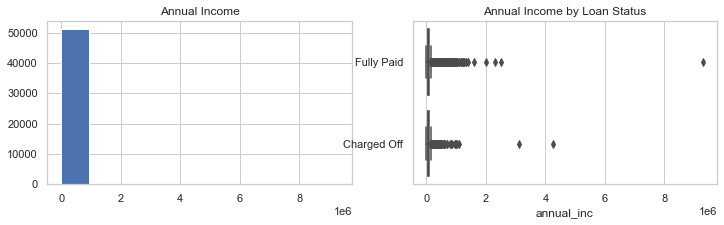

In [47]:
plot_num('annual_inc', 'Annual Income')

* The income range goes form 0 to 9300000 with median of 66000.
* Since it is showing skewness we can take log_transformation.


In [48]:
anova_('annual_inc', 'Annual Income')

Stating Hypothesis:
H0: Annual Income has no effect on loan status
H1: Annual Income has some effect on loan status

Pvalue =  3.205891453899984e-19
Reject Null hypothesis, Annual Income has some effect on loan status.


In [49]:
df1['annual_inc_log'] = df1['annual_inc'].apply(lambda x : np.log(x+1) if x == 0 else np.log(x))
# we are adding 1 in case there is 0, because log of zero is infinite

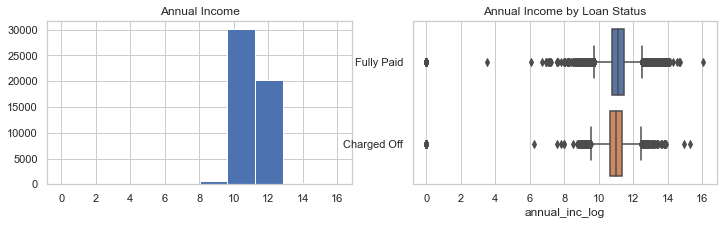

In [50]:
plot_num('annual_inc_log', 'Annual Income')

In [51]:
anova_('annual_inc_log', 'Annual Income')

Stating Hypothesis:
H0: Annual Income has no effect on loan status
H1: Annual Income has some effect on loan status

Pvalue =  6.591018527294685e-33
Reject Null hypothesis, Annual Income has some effect on loan status.


In [52]:
drop_lst.append('annual_inc')

## application_type:

In [53]:
df1['application_type'].unique()

array(['Individual', 'Joint App'], dtype=object)

In [54]:
df1['application_type'].value_counts()

Individual    44756
Joint App      6525
Name: application_type, dtype: int64

* Comparing with Charged off:

In [55]:
df1.groupby('application_type')['loan_status'].value_counts(normalize = True).loc[:,'Charged Off']*100

application_type
Individual    16.420145
Joint App     21.394636
Name: loan_status, dtype: float64

* Joint applicant tend to be more defaulters than individuals.

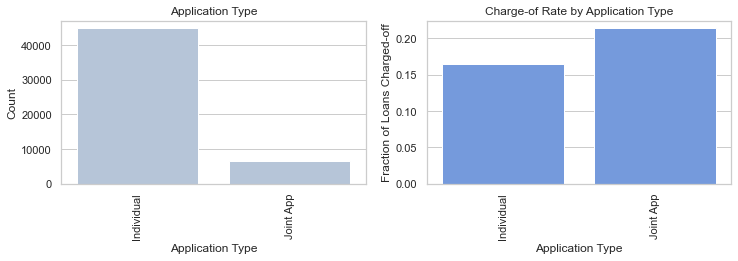

In [56]:
plot_cat('application_type', 'Application Type')

In [57]:
chi2_('application_type', 'Application Type')

Stating Hypothesis:
H0: Application Type has no effect on loan status
H1: Application Type has some effect on loan status

Pvalue =  2.1989598881065364e-23
Reject Null hypothesis, Application Type has some effect on loan status.


## dti:
* Debt-to-income ratio.
* Dti is a ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* This features tells us about applicant's repayment capability.
* Lower dti is better, as it means that applicant has a good monthly income.

In [58]:
df1['dti'].sample(5)

5484     17.61
34101    19.98
736       4.66
7788     12.20
15507    30.97
Name: dti, dtype: float64

In [59]:
df1['dti'].describe()

count    51142.000000
mean        18.502411
std         18.686757
min          0.000000
25%         10.350000
50%         16.715000
75%         23.970000
max        999.000000
Name: dti, dtype: float64

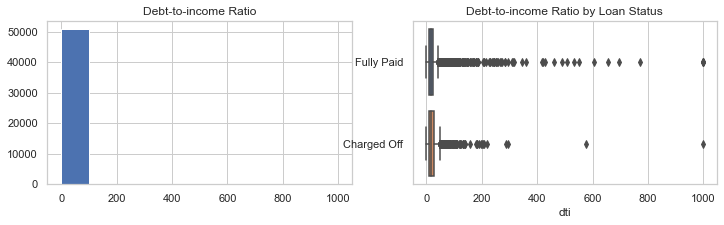

In [60]:
plot_num('dti', 'Debt-to-income Ratio')

In [61]:
anova_('dti', 'Debt-to-income Ratio')

Stating Hypothesis:
H0: Debt-to-income Ratio has no effect on loan status
H1: Debt-to-income Ratio has some effect on loan status

Pvalue =  nan
Reject Null hypothesis, Debt-to-income Ratio has some effect on loan status.


* There are some values which goes as high as 999.
* The data is skewed, we need to do log transformation

In [62]:
df1['dti_log'] = df1['dti'].apply(lambda x : np.log(x+1) if x == 0 else np.log(x))

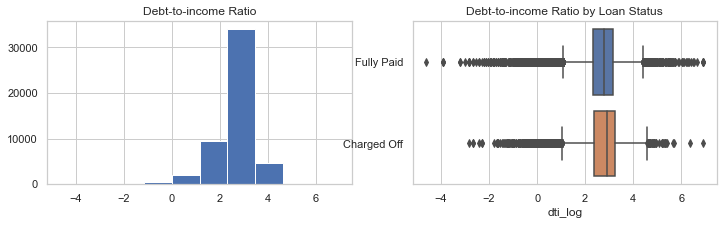

In [63]:
plot_num('dti_log', 'Debt-to-income Ratio')

In [64]:
anova_('dti_log', 'Debt-to-income Ratio')

Stating Hypothesis:
H0: Debt-to-income Ratio has no effect on loan status
H1: Debt-to-income Ratio has some effect on loan status

Pvalue =  nan
Reject Null hypothesis, Debt-to-income Ratio has some effect on loan status.


In [65]:
drop_lst.append('dti')

## earliest_cr_line

In [66]:
df1['earliest_cr_line'].sample(5)

32630    Apr-2013
11002    Aug-2007
4001     Jan-2005
22591    Jul-2000
25423    Dec-2010
Name: earliest_cr_line, dtype: object

In [67]:
df1['earliest_cr_line'] = pd.to_datetime(df1['earliest_cr_line'], format = '%b-%Y')

In [68]:
df1['earliest_cr_line_year'] = df1['earliest_cr_line'].dt.year

In [69]:
df1['earliest_cr_line_year'].isnull().sum()

0

In [70]:
df1['earliest_cr_line_year'].describe()

count    51281.000000
mean      2001.883544
std          7.674886
min       1950.000000
25%       1998.000000
50%       2003.000000
75%       2007.000000
max       2015.000000
Name: earliest_cr_line_year, dtype: float64

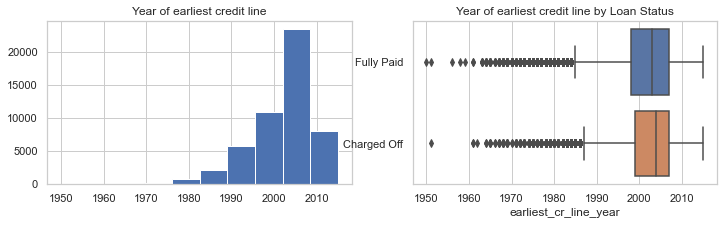

In [71]:
plot_num('earliest_cr_line_year', 'Year of earliest credit line')

In [72]:
anova_('earliest_cr_line_year', 'Year of earliest credit line')

Stating Hypothesis:
H0: Year of earliest credit line has no effect on loan status
H1: Year of earliest credit line has some effect on loan status

Pvalue =  2.3108063495262474e-14
Reject Null hypothesis, Year of earliest credit line has some effect on loan status.


* Most of applicants have a year between 2000 to 2010.


In [73]:
drop_lst.append('earliest_cr_line')

## emp_length

In [74]:
def emp_length(x):
    if x is not np.nan:
        if '<' in x:
            z = '0'
        else:
            z = x.replace('+', '').strip()
            z = z.replace('years', '').strip()
            z = z.replace('year', '').strip()
        return z

In [75]:
df1['emp_length'].unique()

array(['9 years', '10+ years', '< 1 year', '2 years', '5 years',
       '3 years', '4 years', '8 years', '1 year', '7 years', nan,
       '6 years'], dtype=object)

In [76]:
df1['emp_length'] = df1['emp_length'].apply(emp_length)
df1['emp_length'] = pd.to_numeric(df1['emp_length'])

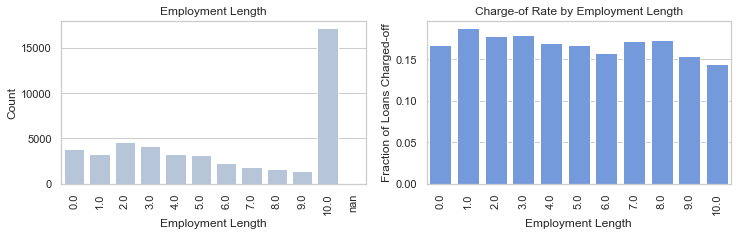

In [77]:
plot_cat('emp_length', 'Employment Length')

* We can see that loan status does not vary much w.r.t. employment lenght.
* Only a slight dip for employment length 10.
* So we'll not keep this column.

In [78]:
drop_lst.append('emp_length')

## emp_title

In [79]:
df1['emp_title'].unique()

array(['Scale Technician', 'SDO Supervisor', 'Parole', ...,
       'EMPLOYMENT SPECIALIST ', 'Police Lt.', 'After-school coordinator'],
      dtype=object)

In [80]:
df1['emp_title'].describe()

count       46577
unique      20816
top       Manager
freq          905
Name: emp_title, dtype: object

* There are so many unique values for job in the emp_title column, we'll drop this feature.

In [81]:
drop_lst.append('emp_title')

## fico_range_high & fico_range_low:
* We'll take average of this high and low range and then it'll give us a fico_score

In [82]:
df1[['fico_range_high', 'fico_range_low']].corr()

,fico_range_high,fico_range_low
fico_range_high,1.0,1.0
fico_range_low,1.0,1.0


* For most of the applicants high and low range is same, but for some of them have different high and low range.
* That's why we are going to take the average of two to get fico_score

In [83]:
df1['fico_score'] = (df1['fico_range_high'] + df1['fico_range_low'])/2

In [84]:
drop_lst.extend(['fico_range_high', 'fico_range_low'])

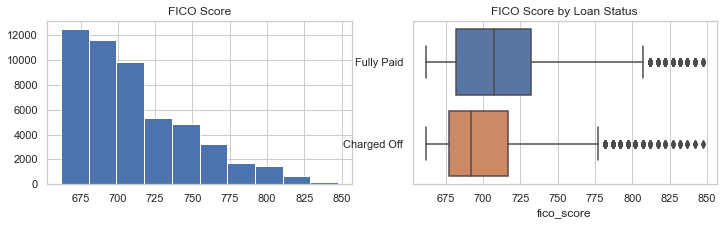

In [85]:
plot_num('fico_score', 'FICO Score')

In [86]:
anova_('fico_score', 'FICO Score')

Stating Hypothesis:
H0: FICO Score has no effect on loan status
H1: FICO Score has some effect on loan status

Pvalue =  7.883416584840414e-122
Reject Null hypothesis, FICO Score has some effect on loan status.


* We can see that for fully paid, fico score tends to be more.

## grade:

In [87]:
df1['grade'].describe()

count     51281
unique        7
top           B
freq      13864
Name: grade, dtype: object

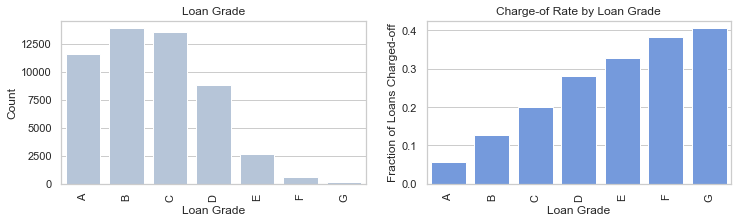

In [88]:
plot_cat('grade', 'Loan Grade')

In [89]:
chi2_('grade', 'Loan Grade')

Stating Hypothesis:
H0: Loan Grade has no effect on loan status
H1: Loan Grade has some effect on loan status

Pvalue =  0.0
Reject Null hypothesis, Loan Grade has some effect on loan status.


* We can see that there is huge impact of Loan grade on charged off.

## home_ownership:
* The home ownership reported by the applicant at the time of application.

In [90]:
df1['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'ANY'], dtype=object)

In [91]:
df1['home_ownership'].value_counts(dropna = False)

MORTGAGE    25793
RENT        18537
OWN          6939
ANY            12
Name: home_ownership, dtype: int64

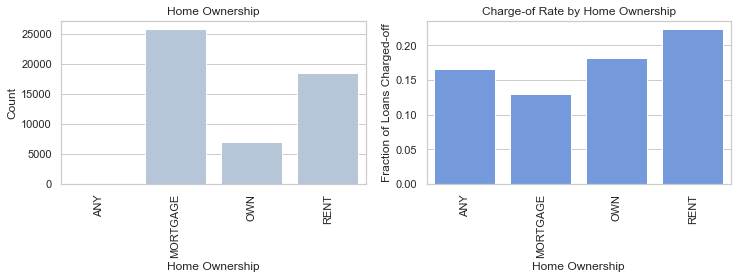

In [92]:
plot_cat('home_ownership', 'Home Ownership')

* RENT have a slightly high percentage of defaulting the loan.

In [93]:
# checking statistically:
chi2_('home_ownership', 'Home Ownership')

Stating Hypothesis:
H0: Home Ownership has no effect on loan status
H1: Home Ownership has some effect on loan status

Pvalue =  1.1959353593513037e-148
Reject Null hypothesis, Home Ownership has some effect on loan status.


* Keeping this feature as it is statistically significant.

## id:

In [94]:
df1['id'].describe()

count         51281
unique        51281
top       132028235
freq              1
Name: id, dtype: int64

In [95]:
df1['id'].nunique()

51281

* Removing all unique values, also this one is used for identifying the record.

In [96]:
drop_lst.append('id')

## initial_list_status:
* w: whole - means whole loan is sponsored by a particular investor
* f: fraction - the loan amount consists of the amount taken from pool of investors, i.e. a small fraction from each investor

In [97]:
df1['initial_list_status'].unique()

array(['w', 'f'], dtype=object)

In [98]:
df1['initial_list_status'].value_counts()

w    42445
f     8836
Name: initial_list_status, dtype: int64

* It's interesting that most number of loans are sponsored.

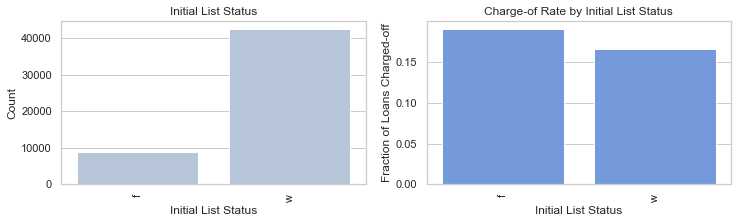

In [99]:
plot_cat('initial_list_status', 'Initial List Status')

In [100]:
df1.groupby('initial_list_status')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()*100

initial_list_status
w    16.638002
f    19.047080
Name: loan_status, dtype: float64

* We can see that the loan given in fraction has a slightly more chances of being default, but it's not much.

In [101]:
# statistical significane:
chi2_('initial_list_status', 'Initial List Status')

Stating Hypothesis:
H0: Initial List Status has no effect on loan status
H1: Initial List Status has some effect on loan status

Pvalue =  4.6993088129149493e-08
Reject Null hypothesis, Initial List Status has some effect on loan status.


## installment
* Fixed monthly installment to payback the loan.

In [102]:
df1['installment'].describe()

count    51281.000000
mean       447.205222
std        293.113862
min         30.120000
25%        225.650000
50%        364.780000
75%        614.900000
max       1628.080000
Name: installment, dtype: float64

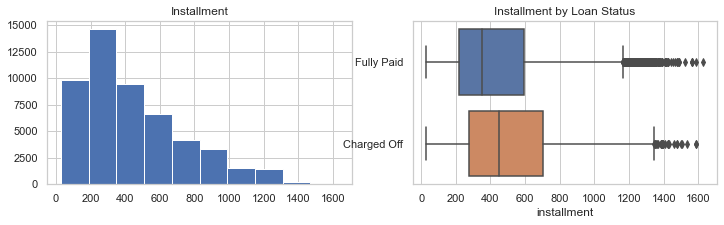

In [103]:
plot_num('installment', 'Installment')

* The minimum installment amount is 30 and it goes as high as 1628.
* Low installment amount have less chance of default.

In [104]:
anova_('installment', 'Installment amount')

Stating Hypothesis:
H0: Installment amount has no effect on loan status
H1: Installment amount has some effect on loan status

Pvalue =  1.3650241536286923e-112
Reject Null hypothesis, Installment amount has some effect on loan status.


## int_rate
* Interest rate charged on the loan amount.

In [105]:
df1['int_rate'].describe()

count    51281.000000
mean        13.379649
std          5.519441
min          5.310000
25%          9.440000
50%         12.610000
75%         16.460000
max         30.990000
Name: int_rate, dtype: float64

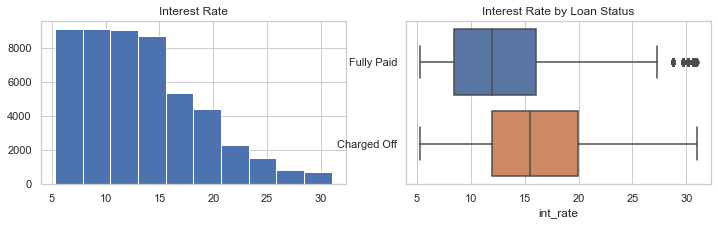

In [106]:
plot_num('int_rate', 'Interest Rate')

* For most of the people the interest rate is from 5 to 20%, but it goest as high as 30 for some people.

In [107]:
df1.loc[:, ['int_rate', 'fico_score']].corr()

,int_rate,fico_score
int_rate,1.000000,-0.479319
fico_score,-0.479319,1.000000


* We can see how FICO score is playing role in deciding interest rate, a bad FICO score attracts more interest rate.

In [108]:
anova_('int_rate', 'Interest Rate')

Stating Hypothesis:
H0: Interest Rate has no effect on loan status
H1: Interest Rate has some effect on loan status

Pvalue =  0.0
Reject Null hypothesis, Interest Rate has some effect on loan status.


## issue_d
* We are going to remove this feature, as it is not available at the time of application.
* Keeping it only to divide the data into train and test.

In [109]:
df1['issue_d'].dtype

dtype('<M8[ns]')

In [110]:
df1['issue_d']

0       2018-03-01
1       2018-03-01
2       2018-03-01
3       2018-03-01
4       2018-03-01
5       2018-03-01
6       2018-03-01
7       2018-03-01
8       2018-03-01
9       2018-03-01
10      2018-03-01
11      2018-03-01
12      2018-03-01
13      2018-03-01
14      2018-03-01
15      2018-03-01
16      2018-03-01
17      2018-03-01
18      2018-03-01
19      2018-03-01
20      2018-03-01
21      2018-03-01
22      2018-03-01
23      2018-03-01
24      2018-03-01
25      2018-03-01
26      2018-03-01
27      2018-03-01
28      2018-03-01
29      2018-03-01
30      2018-03-01
31      2018-03-01
32      2018-03-01
33      2018-03-01
34      2018-03-01
35      2018-03-01
36      2018-03-01
37      2018-03-01
38      2018-03-01
39      2018-03-01
40      2018-03-01
41      2018-03-01
42      2018-03-01
43      2018-03-01
44      2018-03-01
45      2018-03-01
46      2018-03-01
47      2018-03-01
48      2018-03-01
49      2018-03-01
50      2018-03-01
51      2018-03-01
52      2018

* It's an object let's convert it to datetime.

In [111]:
# df1['issue_d'] = pd.to_datetime(df1['issue_d'])

In [112]:
# df1['issue_d'].head()

## loan_amnt

In [113]:
df1['loan_amnt'].describe()

count    51281.000000
mean     14975.394396
std      10130.955537
min       1000.000000
25%       7000.000000
50%      12000.000000
75%      20000.000000
max      40000.000000
Name: loan_amnt, dtype: float64

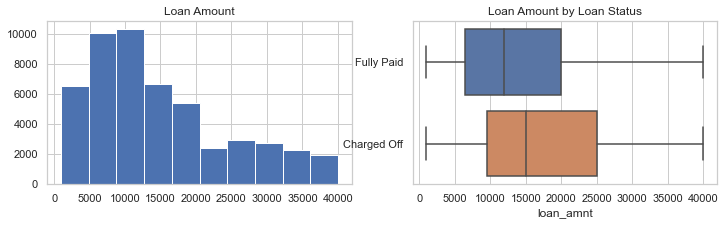

In [114]:
plot_num('loan_amnt', 'Loan Amount')

* Most of the peolpe have applies for loan between 5000 and 10000, with 12000 as median.
* It goes as high as 40000.

In [115]:
df1.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,8745.0,17055.720412,10356.939905,1000.0,9600.0,15000.0,25000.0,40000.0
Fully Paid,42536.0,14547.699008,10030.662608,1000.0,6500.0,12000.0,20000.0,40000.0


* Charged off loans have slightly higher loan amount.

In [116]:
anova_('loan_amnt', 'Loan Amount')

Stating Hypothesis:
H0: Loan Amount has no effect on loan status
H1: Loan Amount has some effect on loan status

Pvalue =  4.21711483089926e-99
Reject Null hypothesis, Loan Amount has some effect on loan status.


## loan_status:
* This is our target variable.

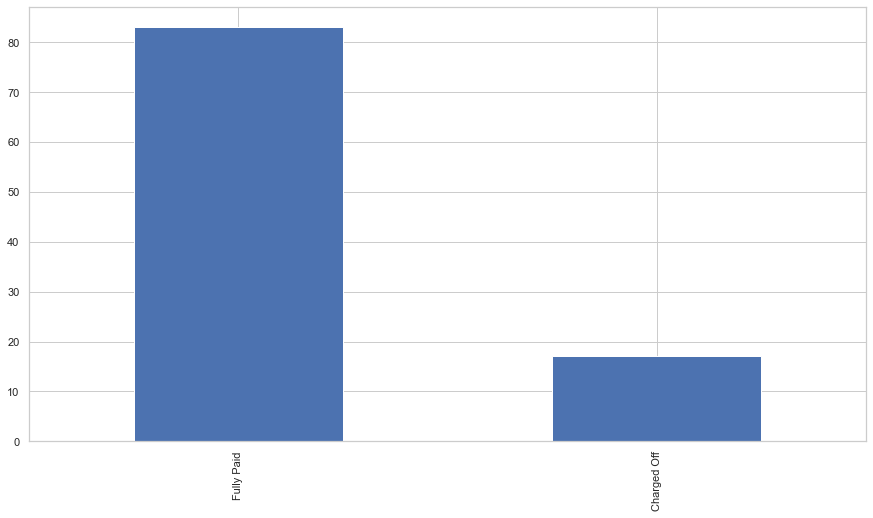

In [117]:
(df1['loan_status'].value_counts(normalize = True)*100).plot(kind = 'bar')
plt.show()

* We can see there is huge imbalnce in the data.
* We may have to use some oversampling technique in order to level this imbalance.

In [118]:
df1['loan_status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [119]:
# label encoding the column:
df1['default'] = df1['loan_status'].map({'Charged Off':1, 'Fully Paid':0})

In [120]:
df1['default'].value_counts(dropna = False)

0    42536
1     8745
Name: default, dtype: int64

In [121]:
drop_lst.append('loan_status')

## mort_acc:
* Number of mortgage account applicant have.
* This tells us about applicant's credit history, as you usually get mortgage loan only when you were good paying back previous loans.

In [122]:
df1['mort_acc'].describe()

count    51281.000000
mean         1.525711
std          1.827199
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         24.000000
Name: mort_acc, dtype: float64

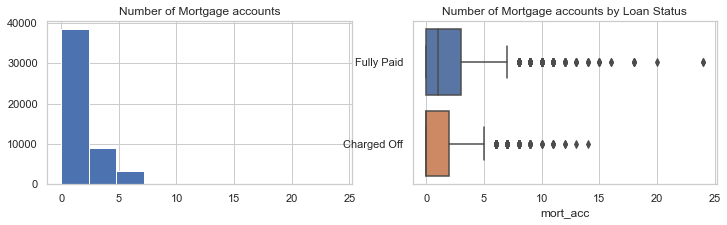

In [123]:
plot_num('mort_acc', 'Number of Mortgage accounts')

* More than 25% of applicant never had a mortgage account.
* Again we can see that people who had a mortgage account tends not to default on the loan.

In [124]:
# statistical significance:
anova_('mort_acc', 'Number of Mortgage accounts')

Stating Hypothesis:
H0: Number of Mortgage accounts has no effect on loan status
H1: Number of Mortgage accounts has some effect on loan status

Pvalue =  8.820049752946932e-116
Reject Null hypothesis, Number of Mortgage accounts has some effect on loan status.


## open_acc:
* Number of active credit lines on the applicants account.

In [125]:
df1['open_acc'].describe()

count    51281.000000
mean        11.393772
std          5.896616
min          0.000000
25%          7.000000
50%         10.000000
75%         14.000000
max         65.000000
Name: open_acc, dtype: float64

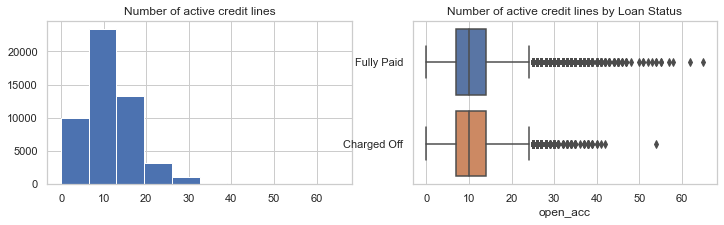

In [126]:
plot_num('open_acc', 'Number of active credit lines')

* As we can see most of the applicants have about 10 active credit lines.
* Number of credit lines can tell us how good the applicant is paying back the credit amount.
* We can see the defaulters have less number of active credit lines.

In [127]:
anova_('open_acc', "Number of active credit lines")

Stating Hypothesis:
H0: Number of active credit lines has no effect on loan status
H1: Number of active credit lines has some effect on loan status

Pvalue =  1.1764777529323256e-23
Reject Null hypothesis, Number of active credit lines has some effect on loan status.


## pub_rec:
* Number of public derogetories.

In [128]:
df1['pub_rec'].describe()

count    51281.00000
mean         0.16082
std          0.41139
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          8.00000
Name: pub_rec, dtype: float64

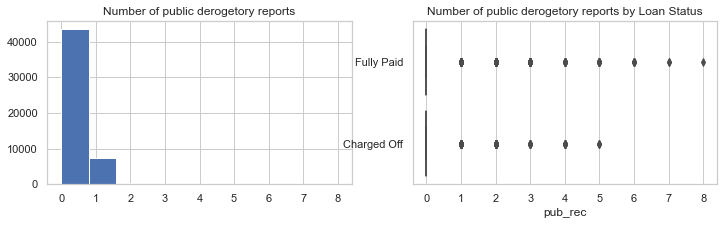

In [129]:
plot_num('pub_rec', 'Number of public derogetory reports')

* Most of the people don't have any public derogetory report.


In [130]:
anova_('pub_rec', 'Number of public derogetory reports')

Stating Hypothesis:
H0: Number of public derogetory reports has no effect on loan status
H1: Number of public derogetory reports has some effect on loan status

Pvalue =  0.04381331285721742
Reject Null hypothesis, Number of public derogetory reports has some effect on loan status.


In [131]:
df1.groupby('pub_rec')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()*100

pub_rec
3.0    14.062500
0.0    16.958796
1.0    17.287488
5.0    21.428571
2.0    25.098039
4.0    45.454545
Name: loan_status, dtype: float64

* We can see applicants having 4 public derogetory reports are having about 45% defaulters.

## pub_rec_bankruptcies:
* Number of public bankruptcies records.


In [132]:
df1['pub_rec_bankruptcies'].describe()

count    51281.000000
mean         0.143172
std          0.356269
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: pub_rec_bankruptcies, dtype: float64

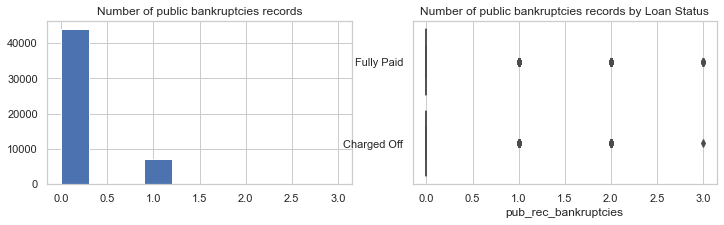

In [133]:
plot_num('pub_rec_bankruptcies', 'Number of public bankruptcies records')

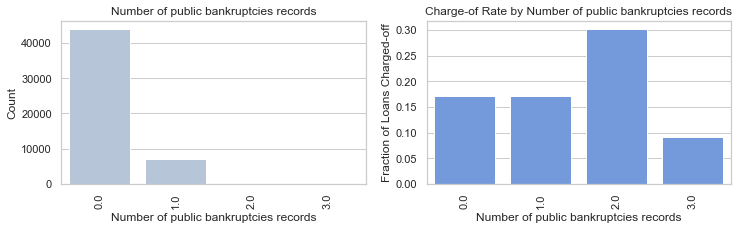

In [134]:
plot_cat('pub_rec_bankruptcies', 'Number of public bankruptcies records')

* We can see that most of the peopl have 0 public bankruptices records.
* Applicants with 2 bankruptcies are having more percentage of defaults.

In [135]:
anova_('pub_rec_bankruptcies', 'Number of public bankruptcies records')

Stating Hypothesis:
H0: Number of public bankruptcies records has no effect on loan status
H1: Number of public bankruptcies records has some effect on loan status

Pvalue =  0.5761727697176846
Fail to reject Null hypothesis, Number of public bankruptcies records has no effect on loan status.


* Even though it seems statistically irrelevant, we're going to keep it as it tells us about the applicant's previous history in bankruptcies.

## purpose:
* Purpose of the loan.

In [136]:
df1['purpose'].describe()

count                  51281
unique                    13
top       debt_consolidation
freq                   26160
Name: purpose, dtype: object

In [137]:
df1.groupby('purpose')['loan_status'].value_counts(normalize = True).loc[:,'Charged Off'].sort_values()*100

purpose
credit_card           13.375181
car                   13.497823
home_improvement      15.107212
debt_consolidation    17.511468
vacation              18.556701
house                 19.047619
other                 19.291180
renewable_energy      19.354839
major_purchase        20.838396
medical               22.305229
moving                22.516556
small_business        34.215501
wedding               50.000000
Name: loan_status, dtype: float64

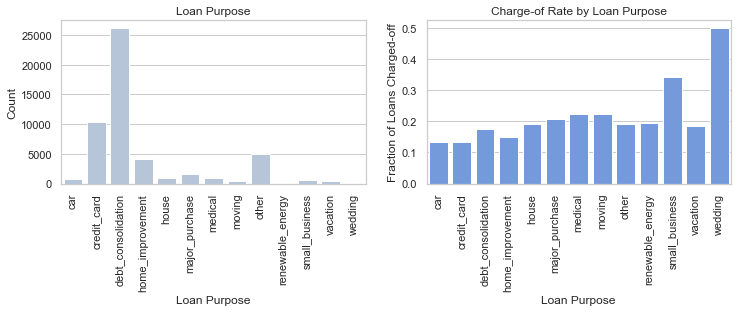

In [138]:
plot_cat('purpose', 'Loan Purpose')

* We can see that small business and weddings seems to have more loan default.
* Default in small business can be explained by the fact that some small business are getting hit by huge dominance of e-commerce services, as these services have entered into practically every segment.

In [139]:
chi2_('purpose', 'Loan Purpose')

Stating Hypothesis:
H0: Loan Purpose has no effect on loan status
H1: Loan Purpose has some effect on loan status

Pvalue =  1.709528181186762e-56
Reject Null hypothesis, Loan Purpose has some effect on loan status.


## revol_bal:
* This is total credit revolving balance.
* After utilizing the available credit balance how much balance is left.

In [140]:
df1['revol_bal'].describe()

count     51281.000000
mean      14322.354342
std       21350.628219
min           0.000000
25%        4103.000000
50%        9086.000000
75%       17379.000000
max      925589.000000
Name: revol_bal, dtype: float64

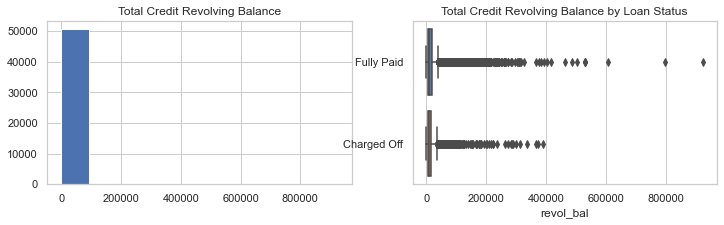

In [141]:
plot_num('revol_bal', 'Total Credit Revolving Balance')

* Those who have defaluted have less credit revolving balance.
* This feature have very high variance, and also most of the people are having 0 credit revolving balance.

In [142]:
anova_('revol_bal', 'Total Credit Revolving Balance')

Stating Hypothesis:
H0: Total Credit Revolving Balance has no effect on loan status
H1: Total Credit Revolving Balance has some effect on loan status

Pvalue =  0.006201267273307246
Reject Null hypothesis, Total Credit Revolving Balance has some effect on loan status.


## revol_util:
* This tells us the rate of credit utilization by the applicant.

In [143]:
df1['revol_util'].describe()

count    51216.000000
mean        39.480209
std         25.571611
min          0.000000
25%         18.500000
50%         36.700000
75%         58.000000
max        132.200000
Name: revol_util, dtype: float64

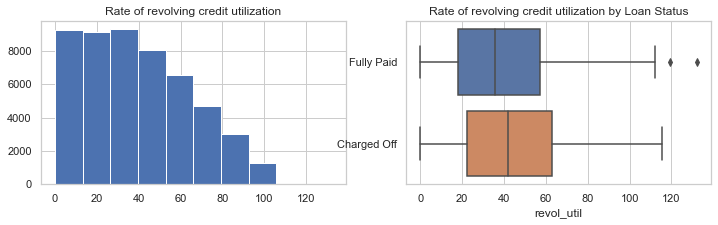

In [144]:
plot_num('revol_util', 'Rate of revolving credit utilization')

In [145]:
anova_('revol_util', 'Rate of revolving credit utilization')

Stating Hypothesis:
H0: Rate of revolving credit utilization has no effect on loan status
H1: Rate of revolving credit utilization has some effect on loan status

Pvalue =  nan
Reject Null hypothesis, Rate of revolving credit utilization has some effect on loan status.


## sub_grade:


In [146]:
df1['sub_grade'].describe()

count     51281
unique       35
top          B5
freq       3056
Name: sub_grade, dtype: object

In [147]:
df1['sub_grade'].value_counts()

B5    3056
B4    2875
B1    2850
C1    2840
C4    2758
C3    2747
B2    2743
A4    2739
C2    2708
C5    2489
A5    2488
A3    2418
B3    2340
A2    2175
D2    1904
D1    1885
A1    1796
D3    1713
D5    1709
D4    1632
E5     724
E3     572
E4     510
E2     443
E1     415
F1     316
G1     110
F2      92
F3      83
F4      66
F5      64
G3      10
G2       5
G4       4
G5       2
Name: sub_grade, dtype: int64

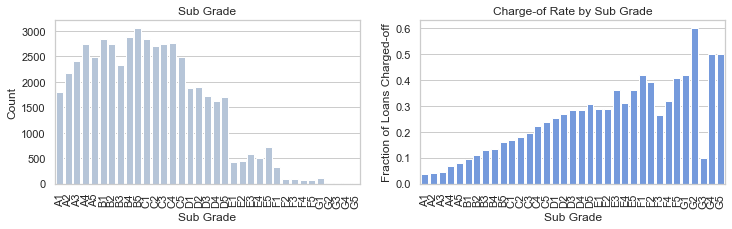

In [148]:
plot_cat('sub_grade', 'Sub Grade')

* We can see that sub grade G2 have more defaults.
* Instead of using grade, we'll use sub-grade.

In [149]:
chi2_('sub_grade', 'Sub Grade')

Stating Hypothesis:
H0: Sub Grade has no effect on loan status
H1: Sub Grade has some effect on loan status

Pvalue =  0.0
Reject Null hypothesis, Sub Grade has some effect on loan status.


In [150]:
drop_lst.append('grade')

## term:
* This is period in months, loan has to repay in these period only.

In [151]:
df1['term'].describe()

count          51281
unique             2
top        36 months
freq           37552
Name: term, dtype: object

* Term contains values like 36months, but we need only numeric part.
* There are only 2 unique values, 36 months and 60 months.

In [152]:
df1['term_months'] = df1['term'].str.split(' ', expand = True)[1]

In [153]:
df1['term_months'] = pd.to_numeric(df1['term_months'])

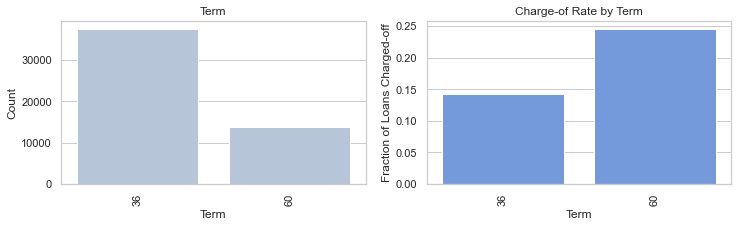

In [154]:
plot_cat('term_months', 'Term')

* We can see that applicants having 60 months as loan term have more percentage of default.

In [155]:
anova_('term_months', 'Term')

Stating Hypothesis:
H0: Term has no effect on loan status
H1: Term has some effect on loan status

Pvalue =  2.696087595838195e-167
Reject Null hypothesis, Term has some effect on loan status.


In [156]:
drop_lst.append('term')

## title:

In [157]:
df1['title'].describe()

count                  51281
unique                    12
top       Debt consolidation
freq                   26160
Name: title, dtype: object

In [158]:
df1['title'].unique()

array(['Major purchase', 'Other', 'Home improvement',
       'Debt consolidation', 'Home buying', 'Credit card refinancing',
       'Car financing', 'Medical expenses', 'Business', 'Vacation',
       'Moving and relocation', 'Green loan'], dtype=object)

* This feature is same as purpose.
* We're dropping this feature.

## total_acc:
* This is the total number of credit lines till date applicant ever had.

In [159]:
df1['total_acc'].describe()

count    51281.000000
mean        24.008756
std         12.729986
min          2.000000
25%         15.000000
50%         22.000000
75%         31.000000
max        125.000000
Name: total_acc, dtype: float64

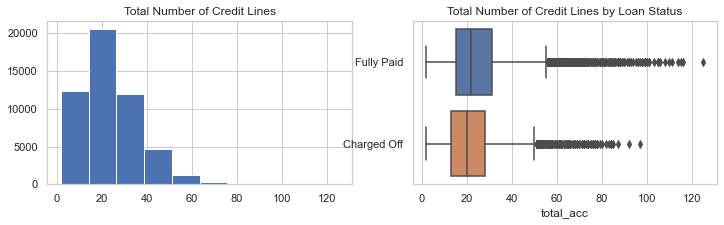

In [160]:
plot_num('total_acc', 'Total Number of Credit Lines')

* Defaulters have less number of total number of credit lines.
* This can mean that they didn't get more credit line because they were not consistent in repaying the loan.

In [161]:
anova_('total_acc', 'Total number of credit lines')

Stating Hypothesis:
H0: Total number of credit lines has no effect on loan status
H1: Total number of credit lines has some effect on loan status

Pvalue =  1.2070352120899376e-75
Reject Null hypothesis, Total number of credit lines has some effect on loan status.


## verification_status:

In [162]:
df1['verification_status'].describe()

count               51281
unique                  3
top       Source Verified
freq                20564
Name: verification_status, dtype: object

In [163]:
df1['verification_status'].unique()

array(['Source Verified', 'Not Verified', 'Verified'], dtype=object)

In [164]:
df1.groupby('verification_status')['loan_status'].value_counts(normalize = True).loc[:, 'Charged Off']*100

verification_status
Not Verified       12.873025
Source Verified    17.010309
Verified           23.720423
Name: loan_status, dtype: float64

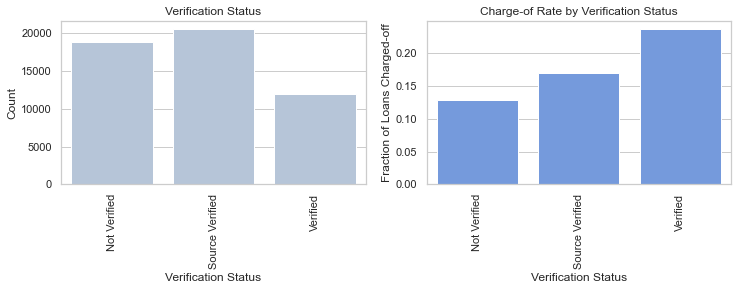

In [165]:
plot_cat('verification_status', 'Verification Status')

* It is interesting, that verified income have more defaulters.


In [166]:
chi2_('verification_status', 'Verification Status')

Stating Hypothesis:
H0: Verification Status has no effect on loan status
H1: Verification Status has some effect on loan status

Pvalue =  1.7262976788331674e-132
Reject Null hypothesis, Verification Status has some effect on loan status.


## zip_code:

In [167]:
df1['zip_code'].describe()

count     51281
unique      864
top       945xx
freq        581
Name: zip_code, dtype: object

* There are 864 unique values, dropping this feature.

In [168]:
drop_lst.append('zip_code')

## total_rev_hi_lim:
* Revolving account is essentially a loan account having varying credit limit.
* Similar to credit card.
* This feature tells about the highest credit limit applicant has/had.

In [169]:
df1['total_rev_hi_lim'].describe()

count    5.128100e+04
mean     3.762628e+04
std      3.671572e+04
min      0.000000e+00
25%      1.570000e+04
50%      2.800000e+04
75%      4.760000e+04
max      1.123500e+06
Name: total_rev_hi_lim, dtype: float64

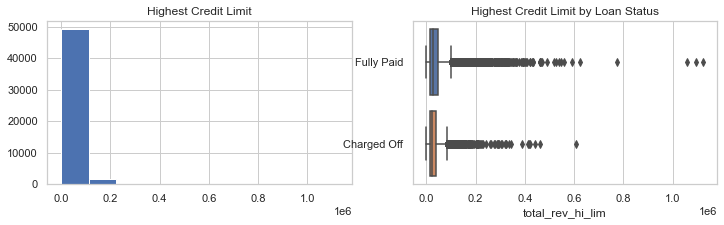

In [170]:
plot_num('total_rev_hi_lim', "Highest Credit Limit")

* Most of the people have 0 credit limit, which is true as most of applicant don't have any revolving account either.
* Again defaulters tends to have lower credit limit as compared to who didn't defaulted the loan.

In [171]:
anova_('total_rev_hi_lim', 'Total Revolving Highest Credit Limit')

Stating Hypothesis:
H0: Total Revolving Highest Credit Limit has no effect on loan status
H1: Total Revolving Highest Credit Limit has some effect on loan status

Pvalue =  3.7436958638877993e-47
Reject Null hypothesis, Total Revolving Highest Credit Limit has some effect on loan status.


## total_bc_limit: 
* This is total limit of credit card.

In [172]:
df1['total_bc_limit'].describe()

count     51281.000000
mean      26048.005948
std       25784.005182
min           0.000000
25%        9200.000000
50%       18500.000000
75%       34200.000000
max      460900.000000
Name: total_bc_limit, dtype: float64

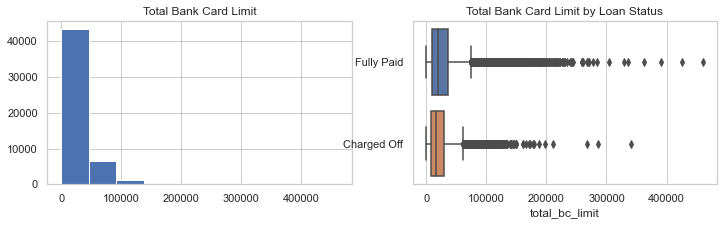

In [173]:
plot_num('total_bc_limit', 'Total Bank Card Limit')

* Charged Off have lower bank card limit.

In [174]:
anova_('total_bc_limit', 'Total Bank Card Limit')

Stating Hypothesis:
H0: Total Bank Card Limit has no effect on loan status
H1: Total Bank Card Limit has some effect on loan status

Pvalue =  7.266454988585603e-55
Reject Null hypothesis, Total Bank Card Limit has some effect on loan status.


## mths_since_rcnt_il:
* This is months since last installment account opened.

In [175]:
df1['mths_since_rcnt_il'].describe()

count    49543.000000
mean        18.104354
std         23.492941
min          0.000000
25%          6.000000
50%         11.000000
75%         21.000000
max        349.000000
Name: mths_since_rcnt_il, dtype: float64

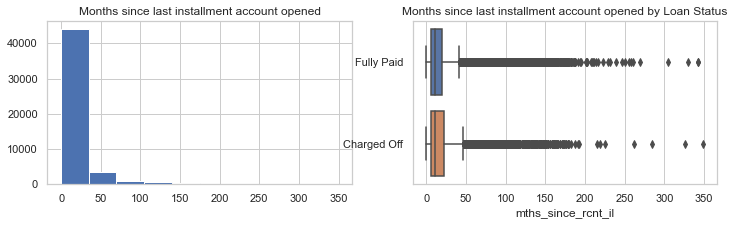

In [176]:
plot_num('mths_since_rcnt_il', 'Months since last installment account opened')

* Most of the applicant never had any installment account.
* Fully paid tend to have more number of installment account.

In [177]:
df1['mths_since_rcnt_il'].isnull().sum()

1738

In [178]:
anova_('mths_since_rcnt_il', 'Months since last installment account opened')

Stating Hypothesis:
H0: Months since last installment account opened has no effect on loan status
H1: Months since last installment account opened has some effect on loan status

Pvalue =  nan
Reject Null hypothesis, Months since last installment account opened has some effect on loan status.


## num_actv_bc_tl:
* Number of total active bank cards on applicant's account as of now.

In [179]:
df1['num_actv_bc_tl'].describe()

count    51281.000000
mean         3.293520
std          2.302681
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         29.000000
Name: num_actv_bc_tl, dtype: float64

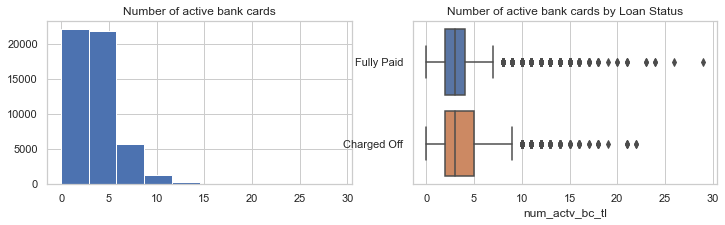

In [180]:
plot_num('num_actv_bc_tl', "Number of active bank cards")

* Most applicants have active bank cards between 0 to 4.
* Those who have charged off tend to have less number of active bank cards

In [181]:
anova_('num_actv_bc_tl', "Number of active bank cards")

Stating Hypothesis:
H0: Number of active bank cards has no effect on loan status
H1: Number of active bank cards has some effect on loan status

Pvalue =  4.674071134500785e-07
Reject Null hypothesis, Number of active bank cards has some effect on loan status.


## il_util:
* It is the ratio of current balance to highest credit limit on all installment accounts.
* This ratio, if bigger means applican have more balance and less credit is utilized.

In [182]:
df1['il_util'].describe()

count    42748.000000
mean        71.271381
std         22.576208
min          0.000000
25%         58.000000
50%         74.000000
75%         87.000000
max        272.000000
Name: il_util, dtype: float64

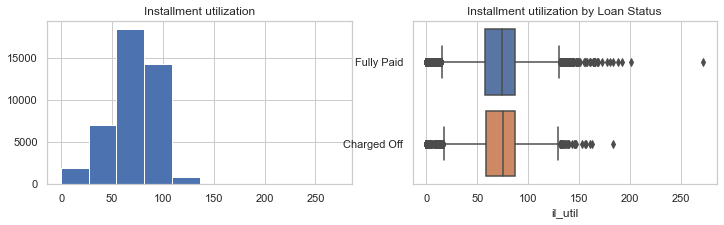

In [183]:
plot_num('il_util', 'Installment utilization')

In [184]:
df1['il_util'].isnull().sum()/df1.shape[0]*100

16.63969111366783

* Missing value imputation is needed.

In [185]:
drop_lst = list(set(drop_lst))

# 6. BUILDING BASE MODEL:

## 6.1 Creating Final DataFrame

In [186]:
df2 = df1.drop(columns = drop_lst)

In [187]:
df2.shape

(51281, 30)

In [188]:
df2.head()

,title,int_rate,home_ownership,issue_d,il_util,verification_status,pub_rec,total_bc_limit,installment,initial_list_status,open_acc,application_type,purpose,total_rev_hi_lim,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,revol_util,sub_grade,mths_since_rcnt_il,mort_acc,total_acc,revol_bal,add_region,annual_inc_log,dti_log,earliest_cr_line_year,fico_score,default,term_months
0,Major purchase,7.34,RENT,2018-03-01,NaN,Source Verified,0.0,30500.0,93.10,w,7.0,Individual,major_purchase,31000.0,3000.0,1.0,0.0,0.5,A4,7.0,4.0,30.0,141.0,Region 10,10.858999,-0.544727,1998,762.0,0,36
1,Other,11.98,OWN,2018-03-01,63.0,Not Verified,1.0,22000.0,166.03,w,14.0,Individual,other,33800.0,5000.0,3.0,1.0,33.9,B5,33.0,0.0,24.0,11449.0,Region 4,10.915088,2.651833,2001,677.0,0,36
2,Home improvement,11.98,MORTGAGE,2018-03-01,102.0,Verified,0.0,10000.0,232.44,w,13.0,Individual,home_improvement,13900.0,7000.0,2.0,0.0,36.0,B5,16.0,0.0,29.0,5004.0,Region 6,10.596635,3.008155,2007,697.0,0,36
3,Debt consolidation,21.85,OWN,2018-03-01,94.0,Verified,0.0,29400.0,1143.39,w,11.0,Individual,debt_consolidation,55500.0,30000.0,3.0,0.0,53.2,D5,6.0,2.0,26.0,29222.0,Region 4,10.950807,3.317091,2000,682.0,0,36
4,Home buying,20.39,OWN,2018-03-01,NaN,Source Verified,0.0,27100.0,560.94,w,15.0,Individual,house,42700.0,21000.0,5.0,0.0,34.2,D4,7.0,3.0,27.0,14591.0,Region 2,11.350407,2.757475,2008,667.0,0,60


Checking for missing values:

In [189]:
df2.isnull().sum()

title                       0
int_rate                    0
home_ownership              0
issue_d                     0
il_util                  8533
verification_status         0
pub_rec                     0
total_bc_limit              0
installment                 0
initial_list_status         0
open_acc                    0
application_type            0
purpose                     0
total_rev_hi_lim            0
loan_amnt                   0
num_actv_bc_tl              0
pub_rec_bankruptcies        0
revol_util                 65
sub_grade                   0
mths_since_rcnt_il       1738
mort_acc                    0
total_acc                   0
revol_bal                   0
add_region                  0
annual_inc_log              0
dti_log                   139
earliest_cr_line_year       0
fico_score                  0
default                     0
term_months                 0
dtype: int64

In [190]:
df_num = df2.select_dtypes(include = np.number)
df_other = df2.select_dtypes(exclude = np.number)

In [191]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51281 entries, 0 to 51280
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   int_rate               51281 non-null  float64
 1   il_util                42748 non-null  float64
 2   pub_rec                51281 non-null  float64
 3   total_bc_limit         51281 non-null  float64
 4   installment            51281 non-null  float64
 5   open_acc               51281 non-null  float64
 6   total_rev_hi_lim       51281 non-null  float64
 7   loan_amnt              51281 non-null  float64
 8   num_actv_bc_tl         51281 non-null  float64
 9   pub_rec_bankruptcies   51281 non-null  float64
 10  revol_util             51216 non-null  float64
 11  mths_since_rcnt_il     49543 non-null  float64
 12  mort_acc               51281 non-null  float64
 13  total_acc              51281 non-null  float64
 14  revol_bal              51281 non-null  float64
 15  an

In [192]:
# imputing missing values using KNN Imputer:
knn_imputer = KNNImputer()
clean_data = knn_imputer.fit_transform(df_num)
df_num = pd.DataFrame(clean_data, columns = df_num.columns)

In [193]:
df3 = pd.concat([df_num, df_other], axis = 1)
df3.shape

(51281, 30)

In [194]:
df_dummy = pd.get_dummies(df3, drop_first = True)

In [195]:
df_dummy.shape

(51281, 95)

In [196]:
df_new = df_dummy.drop(["issue_d","default"],axis=1)

In [197]:
df_new.shape

(51281, 93)

In [198]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51281 entries, 0 to 51280
Data columns (total 93 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   int_rate                             51281 non-null  float64
 1   il_util                              51281 non-null  float64
 2   pub_rec                              51281 non-null  float64
 3   total_bc_limit                       51281 non-null  float64
 4   installment                          51281 non-null  float64
 5   open_acc                             51281 non-null  float64
 6   total_rev_hi_lim                     51281 non-null  float64
 7   loan_amnt                            51281 non-null  float64
 8   num_actv_bc_tl                       51281 non-null  float64
 9   pub_rec_bankruptcies                 51281 non-null  float64
 10  revol_util                           51281 non-null  float64
 11  mths_since_rcnt_il          

In [199]:
from sklearn.preprocessing import StandardScaler

In [200]:
ss = StandardScaler()
df_new_sc = ss.fit_transform(df_new)

In [201]:
df_new_sc

array([[-1.09426091, -0.06270663, -0.39092184, ..., -0.16771593,
        -0.21689281, -0.49499179],
       [-0.25358783, -0.39509115,  2.03988487, ..., -0.16771593,
        -0.21689281, -0.49499179],
       [-0.25358783,  1.45676546, -0.39092184, ..., -0.16771593,
        -0.21689281, -0.49499179],
       ...,
       [-0.25358783, -1.86707974, -0.39092184, ..., -0.16771593,
        -0.21689281,  2.02023552],
       [ 0.03629943, -2.43688178, -0.39092184, ..., -0.16771593,
        -0.21689281, -0.49499179],
       [-0.25358783, -1.77211274,  2.03988487, ..., -0.16771593,
        -0.21689281,  2.02023552]])

In [202]:
df_new_sc = pd.DataFrame(df_new_sc, columns = df_new.columns)

In [203]:
df_new_sc.head()

,int_rate,il_util,pub_rec,total_bc_limit,installment,open_acc,total_rev_hi_lim,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,revol_util,mths_since_rcnt_il,mort_acc,total_acc,revol_bal,annual_inc_log,dti_log,earliest_cr_line_year,fico_score,term_months,title_Car financing,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,add_region_Region 10,add_region_Region 2,add_region_Region 3,add_region_Region 4,add_region_Region 5,add_region_Region 6,add_region_Region 7,add_region_Region 8,add_region_Region 9
0,-1.094261,-0.062707,-0.390922,0.172667,-1.208093,-0.745142,-0.180477,-1.182071,-0.996031,-0.401869,-1.523338,-0.480511,1.354156,0.470645,-0.664219,-0.262609,-3.996279,-0.506012,1.364971,-0.604648,-0.116699,-0.503009,-1.02047,-0.024594,-0.135458,-0.294943,5.491350,-0.136426,-0.094406,-0.327521,-0.097714,-1.005965,-0.395586,1.329065,1.222181,-0.550247,0.456262,-0.381825,-0.503009,-1.02047,-0.294943,-0.135458,5.491350,-0.136426,-0.094406,-0.327448,-0.024594,-0.102094,-0.097714,-0.006245,-0.210457,-0.222453,4.209813,-0.225812,-0.242583,-0.237723,-0.218661,-0.243708,-0.251733,-0.242132,-0.236117,-0.237906,-0.238409,-0.225859,-0.195348,-0.196368,-0.185899,-0.181303,-0.185675,-0.090325,-0.093349,-0.106208,-0.100225,-0.119668,-0.078742,-0.042394,-0.040264,-0.035898,-0.035349,-0.046364,-0.009875,-0.013966,-0.008832,-0.006245,4.781498,-0.342464,-0.317386,-0.489397,-0.396443,-0.356830,-0.167716,-0.216893,-0.494992
1,-0.253588,-0.395091,2.039885,-0.156998,-0.959279,0.441991,-0.104215,-0.984655,-0.127470,2.405029,-0.217204,0.640518,-0.835008,-0.000688,-0.134581,-0.194427,-0.013621,-0.115123,-0.875459,-0.604648,-0.116699,-0.503009,-1.02047,-0.024594,-0.135458,-0.294943,-0.182105,-0.136426,-0.094406,3.053238,-0.097714,-1.005965,2.527896,-0.752409,-0.818209,-0.550247,0.456262,-0.381825,-0.503009,-1.02047,-0.294943,-0.135458,-0.182105,-0.136426,-0.094406,3.053919,-0.024594,-0.102094,-0.097714,-0.006245,-0.210457,-0.222453,-0.237540,-0.225812,-0.242583,-0.237723,-0.218661,-0.243708,3.972459,-0.242132,-0.236117,-0.237906,-0.238409,-0.225859,-0.195348,-0.196368,-0.185899,-0.181303,-0.185675,-0.090325,-0.093349,-0.106208,-0.100225,-0.119668,-0.078742,-0.042394,-0.040264,-0.035898,-0.035349,-0.046364,-0.009875,-0.013966,-0.008832,-0.006245,-0.209139,-0.342464,-0.317386,2.043329,-0.396443,-0.356830,-0.167716,-0.216893,-0.494992
2,-0.253588,1.456765,-0.390922,-0.622408,-0.732710,0.272401,-0.646222,-0.787238,-0.561751,-0.401869,-0.135082,-0.092463,-0.835008,0.392089,-0.436448,-0.581538,0.430328,0.666656,-0.348299,-0.604648,-0.116699,-0.503009,-1.02047,-0.024594,-0.135458,3.390482,-0.182105,-0.136426,-0.094406,-0.327521,-0.097714,0.994070,-0.395586,-0.752409,-0.818209,1.817366,0.456262,-0.381825,-0.503009,-1.02047,3.390482,-0.135458,-0.182105,-0.136426,-0.094406,-0.327448,-0.024594,-0.102094,-0.097714,-0.006245,-0.210457,-0.222453,-0.237540,-0.225812,-0.242583,-0.237723,-0.218661,-0.243708,3.972459,-0.242132,-0.236117,-0.237906,-0.238409,-0.225859,-0.195348,-0.

In [204]:
df_new_sc['issue_d'] = df_dummy['issue_d']

In [205]:
df_new_sc['default'] = df_dummy['default']

## 6.2 Train Test Split:
* Here we'll take first two quarters as training set and next quarter as test set.


In [206]:
df_dummy.head()

,int_rate,il_util,pub_rec,total_bc_limit,installment,open_acc,total_rev_hi_lim,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,revol_util,mths_since_rcnt_il,mort_acc,total_acc,revol_bal,annual_inc_log,dti_log,earliest_cr_line_year,fico_score,default,term_months,issue_d,title_Car financing,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,add_region_Region 10,add_region_Region 2,add_region_Region 3,add_region_Region 4,add_region_Region 5,add_region_Region 6,add_region_Region 7,add_region_Region 8,add_region_Region 9
0,7.34,70.0,0.0,30500.0,93.10,7.0,31000.0,3000.0,1.0,0.0,0.5,7.0,4.0,30.0,141.0,10.858999,-0.544727,1998.0,762.0,0.0,36.0,2018-03-01,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,11.98,63.0,1.0,22000.0,166.03,14.0,33800.0,5000.0,3.0,1.0,33.9,33.0,0.0,24.0,11449.0,10.915088,2.651833,2001.0,677.0,0.0,36.0,2018-03-01,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,11.98,102.0,0.0,10000.0,232.44,13.0,13900.0,7000.0,2.0,0.0,36.0,16.0,0.0,29.0,5004.0,10.596635,3.008155,2007.0,697.0,0.0,36.0,2018-03-01,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,21.85,94.0,0.0,29400.0,1143.39,11.0,55500.0,30000.0,3.0,0.0,53.2,6.0,2.0,26.0,29222.0,10.950807,3.317091,2000.0,682.0,0.0,36.0,2018-03-01,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,20.39,61.6,0.0,27100.0,560.94,15.0,42700.0,21000.0,5.0,0.0,34.2,7.0,3.0,27.0,14591.0,11.350407,2.757475,2008.0,667.0,0.0,60.0,2018-03-01,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [207]:
train = df_new_sc[df_new_sc['issue_d'] < '2018-07-1']
test = df_new_sc[df_new_sc['issue_d'] >= '2018-07-1']

In [208]:
train.shape, test.shape, df3.shape

((40973, 95), (10308, 95), (51281, 30))

In [209]:
train1 = train.drop('issue_d', 1)
test1 = test.drop('issue_d', 1)

In [210]:
xtrain = train1.drop('default', 1)
xtest = test1.drop('default', 1)

ytrain = train1['default']
ytest = test1['default']

In [211]:
xtrain.shape,xtest.shape,ytrain.shape,ytest.shape

((40973, 93), (10308, 93), (40973,), (10308,))

In [212]:
xtrain.head()

,int_rate,il_util,pub_rec,total_bc_limit,installment,open_acc,total_rev_hi_lim,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,revol_util,mths_since_rcnt_il,mort_acc,total_acc,revol_bal,annual_inc_log,dti_log,earliest_cr_line_year,fico_score,term_months,title_Car financing,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,add_region_Region 10,add_region_Region 2,add_region_Region 3,add_region_Region 4,add_region_Region 5,add_region_Region 6,add_region_Region 7,add_region_Region 8,add_region_Region 9
0,-1.094261,-0.062707,-0.390922,0.172667,-1.208093,-0.745142,-0.180477,-1.182071,-0.996031,-0.401869,-1.523338,-0.480511,1.354156,0.470645,-0.664219,-0.262609,-3.996279,-0.506012,1.364971,-0.604648,-0.116699,-0.503009,-1.02047,-0.024594,-0.135458,-0.294943,5.491350,-0.136426,-0.094406,-0.327521,-0.097714,-1.005965,-0.395586,1.329065,1.222181,-0.550247,0.456262,-0.381825,-0.503009,-1.02047,-0.294943,-0.135458,5.491350,-0.136426,-0.094406,-0.327448,-0.024594,-0.102094,-0.097714,-0.006245,-0.210457,-0.222453,4.209813,-0.225812,-0.242583,-0.237723,-0.218661,-0.243708,-0.251733,-0.242132,-0.236117,-0.237906,-0.238409,-0.225859,-0.195348,-0.196368,-0.185899,-0.181303,-0.185675,-0.090325,-0.093349,-0.106208,-0.100225,-0.119668,-0.078742,-0.042394,-0.040264,-0.035898,-0.035349,-0.046364,-0.009875,-0.013966,-0.008832,-0.006245,4.781498,-0.342464,-0.317386,-0.489397,-0.396443,-0.356830,-0.167716,-0.216893,-0.494992
1,-0.253588,-0.395091,2.039885,-0.156998,-0.959279,0.441991,-0.104215,-0.984655,-0.127470,2.405029,-0.217204,0.640518,-0.835008,-0.000688,-0.134581,-0.194427,-0.013621,-0.115123,-0.875459,-0.604648,-0.116699,-0.503009,-1.02047,-0.024594,-0.135458,-0.294943,-0.182105,-0.136426,-0.094406,3.053238,-0.097714,-1.005965,2.527896,-0.752409,-0.818209,-0.550247,0.456262,-0.381825,-0.503009,-1.02047,-0.294943,-0.135458,-0.182105,-0.136426,-0.094406,3.053919,-0.024594,-0.102094,-0.097714,-0.006245,-0.210457,-0.222453,-0.237540,-0.225812,-0.242583,-0.237723,-0.218661,-0.243708,3.972459,-0.242132,-0.236117,-0.237906,-0.238409,-0.225859,-0.195348,-0.196368,-0.185899,-0.181303,-0.185675,-0.090325,-0.093349,-0.106208,-0.100225,-0.119668,-0.078742,-0.042394,-0.040264,-0.035898,-0.035349,-0.046364,-0.009875,-0.013966,-0.008832,-0.006245,-0.209139,-0.342464,-0.317386,2.043329,-0.396443,-0.356830,-0.167716,-0.216893,-0.494992
2,-0.253588,1.456765,-0.390922,-0.622408,-0.732710,0.272401,-0.646222,-0.787238,-0.561751,-0.401869,-0.135082,-0.092463,-0.835008,0.392089,-0.436448,-0.581538,0.430328,0.666656,-0.348299,-0.604648,-0.116699,-0.503009,-1.02047,-0.024594,-0.135458,3.390482,-0.182105,-0.136426,-0.094406,-0.327521,-0.097714,0.994070,-0.395586,-0.752409,-0.818209,1.817366,0.456262,-0.381825,-0.503009,-1.02047,3.390482,-0.135458,-0.182105,-0.136426,-0.094406,-0.327448,-0.024594,-0.102094,-0.097714,-0.006245,-0.210457,-0.222453,-0.237540,-0.225812,-0.242583,-0.237723,-0.218661,-0.243708,3.972459,-0.242132,-0.236117,-0.237906,-0.238409,-0.225859,-0.195348,-0.

## 6.4 Building base model using Logistic Regression:

In [213]:
log_reg1 = LogisticRegression()
log_reg1.fit(xtrain, ytrain)

LogisticRegression()

In [214]:
cm = confusion_matrix(ytrain, log_reg1.predict(xtrain))
print(cm)

[[32813   432]
 [ 7171   557]]


In [215]:
ytrain.value_counts()

0.0    33245
1.0     7728
Name: default, dtype: int64

In [216]:
ytest.value_counts()

0.0    9291
1.0    1017
Name: default, dtype: int64

In [217]:
def report_(true, pred):
  print("Accuracy = ", accuracy_score(true, pred))
  print("Recall = ", recall_score(true, pred))
  print("Precision = ", precision_score(true, pred))
  print("F1_score = ", f1_score(true, pred))


In [218]:
report_(ytrain, log_reg1.predict(xtrain))

Accuracy =  0.8144387767554243
Recall =  0.07207556935817805
Precision =  0.5631951466127402
F1_score =  0.127796260181255


In [219]:
report_(ytest, log_reg1.predict(xtest))

Accuracy =  0.8961001164144354
Recall =  0.06096361848574238
Precision =  0.34831460674157305
F1_score =  0.10376569037656905


We can see that model is not working great. Though accuracy score is good, but F1 score is not.

In [220]:
# checking feature importance:
pd.DataFrame({"Features": xtrain.columns, "Importance": log_reg1.coef_[0]})

,Features,Importance
0,int_rate,-0.448419
1,il_util,-0.017189
2,pub_rec,0.016167
3,total_bc_limit,-0.184326
4,installment,0.284076
5,open_acc,-0.069740
6,total_rev_hi_lim,0.165836
7,loan_amnt,-0.052473
8,num_actv_bc_tl,0.170710
9,pub_rec_bankruptcies,-0.015796


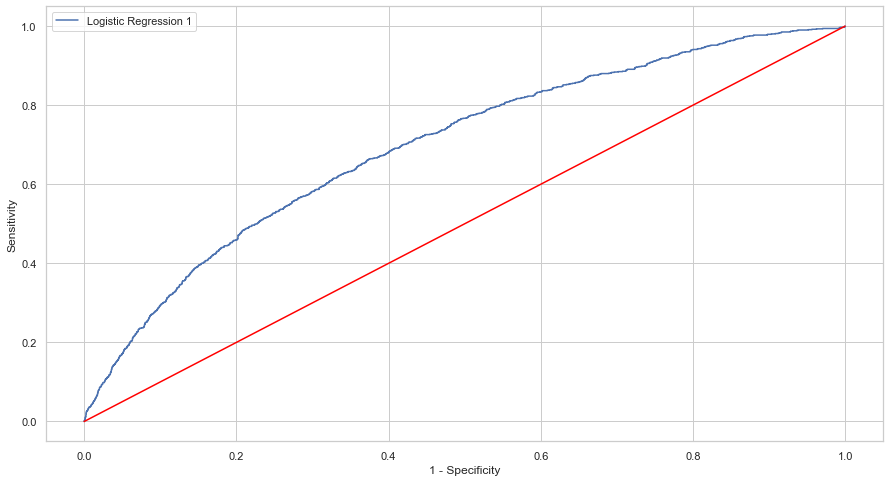

In [221]:
yscore_lr1 = cross_val_predict(log_reg1, xtest, ytest, cv = 3, method = 'decision_function')
fpr_lr1, tpr_lr1, th = roc_curve(ytest, yscore_lr1)

plt.plot(fpr_lr1, tpr_lr1, label = "Logistic Regression 1")
plt.legend()
plt.plot([0, 1], [0, 1], color = 'red')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()


In [222]:
print(fpr_lr1, tpr_lr1, th)

[0.00000000e+00 0.00000000e+00 3.22893122e-04 ... 9.99677107e-01
 9.99677107e-01 1.00000000e+00] [0.00000000e+00 9.83284169e-04 9.83284169e-04 ... 9.99016716e-01
 1.00000000e+00 1.00000000e+00] [ 9.23859827  8.23859827  1.06072179 ... -7.53959122 -7.63823196
 -8.33759168]


In [223]:
print(fpr_lr2, tpr_lr2, th)

NameError: name 'fpr_lr2' is not defined

In [ ]:
f1 = pd.DataFrame({'lr1':fpr_lr1[0:20],'lr2':fpr_lr2[0:20]})

In [ ]:
f1

In [224]:
confusion_matrix(ytest, log_reg1.predict(xtest))

array([[9175,  116],
       [ 955,   62]], dtype=int64)

In [225]:
# Before SMOTE
# Accuracy =  0.8961001164144354
# Recall =  0.06096361848574238
# Precision =  0.34831460674157305
# F1_score =  0.10376569037656905

In [230]:
# After SMOTE
# Accuracy =  0.6753977493209158
# Recall =  0.6312684365781711
# Precision =  0.1776916689731525
# F1_score =  0.27732181425485963

# 7. Improving model performance:

## 7.1 Correcting the imbalance in the data.

In [231]:
smote = SMOTE()
xtrain_new, ytrain_new = smote.fit_resample(xtrain, ytrain)
xtrain_new = pd.DataFrame(xtrain_new, columns = xtrain.columns)


In [232]:
ytrain_new.value_counts()

1.0    33245
0.0    33245
Name: default, dtype: int64

In [233]:
xtrain.head()

,int_rate,il_util,pub_rec,total_bc_limit,installment,open_acc,total_rev_hi_lim,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,revol_util,mths_since_rcnt_il,mort_acc,total_acc,revol_bal,annual_inc_log,dti_log,earliest_cr_line_year,fico_score,term_months,title_Car financing,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,add_region_Region 10,add_region_Region 2,add_region_Region 3,add_region_Region 4,add_region_Region 5,add_region_Region 6,add_region_Region 7,add_region_Region 8,add_region_Region 9
0,-1.094261,-0.062707,-0.390922,0.172667,-1.208093,-0.745142,-0.180477,-1.182071,-0.996031,-0.401869,-1.523338,-0.480511,1.354156,0.470645,-0.664219,-0.262609,-3.996279,-0.506012,1.364971,-0.604648,-0.116699,-0.503009,-1.02047,-0.024594,-0.135458,-0.294943,5.491350,-0.136426,-0.094406,-0.327521,-0.097714,-1.005965,-0.395586,1.329065,1.222181,-0.550247,0.456262,-0.381825,-0.503009,-1.02047,-0.294943,-0.135458,5.491350,-0.136426,-0.094406,-0.327448,-0.024594,-0.102094,-0.097714,-0.006245,-0.210457,-0.222453,4.209813,-0.225812,-0.242583,-0.237723,-0.218661,-0.243708,-0.251733,-0.242132,-0.236117,-0.237906,-0.238409,-0.225859,-0.195348,-0.196368,-0.185899,-0.181303,-0.185675,-0.090325,-0.093349,-0.106208,-0.100225,-0.119668,-0.078742,-0.042394,-0.040264,-0.035898,-0.035349,-0.046364,-0.009875,-0.013966,-0.008832,-0.006245,4.781498,-0.342464,-0.317386,-0.489397,-0.396443,-0.356830,-0.167716,-0.216893,-0.494992
1,-0.253588,-0.395091,2.039885,-0.156998,-0.959279,0.441991,-0.104215,-0.984655,-0.127470,2.405029,-0.217204,0.640518,-0.835008,-0.000688,-0.134581,-0.194427,-0.013621,-0.115123,-0.875459,-0.604648,-0.116699,-0.503009,-1.02047,-0.024594,-0.135458,-0.294943,-0.182105,-0.136426,-0.094406,3.053238,-0.097714,-1.005965,2.527896,-0.752409,-0.818209,-0.550247,0.456262,-0.381825,-0.503009,-1.02047,-0.294943,-0.135458,-0.182105,-0.136426,-0.094406,3.053919,-0.024594,-0.102094,-0.097714,-0.006245,-0.210457,-0.222453,-0.237540,-0.225812,-0.242583,-0.237723,-0.218661,-0.243708,3.972459,-0.242132,-0.236117,-0.237906,-0.238409,-0.225859,-0.195348,-0.196368,-0.185899,-0.181303,-0.185675,-0.090325,-0.093349,-0.106208,-0.100225,-0.119668,-0.078742,-0.042394,-0.040264,-0.035898,-0.035349,-0.046364,-0.009875,-0.013966,-0.008832,-0.006245,-0.209139,-0.342464,-0.317386,2.043329,-0.396443,-0.356830,-0.167716,-0.216893,-0.494992
2,-0.253588,1.456765,-0.390922,-0.622408,-0.732710,0.272401,-0.646222,-0.787238,-0.561751,-0.401869,-0.135082,-0.092463,-0.835008,0.392089,-0.436448,-0.581538,0.430328,0.666656,-0.348299,-0.604648,-0.116699,-0.503009,-1.02047,-0.024594,-0.135458,3.390482,-0.182105,-0.136426,-0.094406,-0.327521,-0.097714,0.994070,-0.395586,-0.752409,-0.818209,1.817366,0.456262,-0.381825,-0.503009,-1.02047,3.390482,-0.135458,-0.182105,-0.136426,-0.094406,-0.327448,-0.024594,-0.102094,-0.097714,-0.006245,-0.210457,-0.222453,-0.237540,-0.225812,-0.242583,-0.237723,-0.218661,-0.243708,3.972459,-0.242132,-0.236117,-0.237906,-0.238409,-0.225859,-0.195348,-0.

In [234]:
# 2018 - earliest_cr_line_year(need to do)

In [235]:
ytest.value_counts()

0.0    9291
1.0    1017
Name: default, dtype: int64

In [236]:
xtrain.columns

Index(['int_rate', 'il_util', 'pub_rec', 'total_bc_limit', 'installment',
       'open_acc', 'total_rev_hi_lim', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies', 'revol_util', 'mths_since_rcnt_il', 'mort_acc',
       'total_acc', 'revol_bal', 'annual_inc_log', 'dti_log',
       'earliest_cr_line_year', 'fico_score', 'term_months',
       'title_Car financing', 'title_Credit card refinancing',
       'title_Debt consolidation', 'title_Green loan', 'title_Home buying',
       'title_Home improvement', 'title_Major purchase',
       'title_Medical expenses', 'title_Moving and relocation', 'title_Other',
       'title_Vacation', 'home_ownership_MORTGAGE', 'home_ownership_OWN',
       'home_ownership_RENT', 'verification_status_Source Verified',
       'verification_status_Verified', 'initial_list_status_w',
       'application_type_Joint App', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase

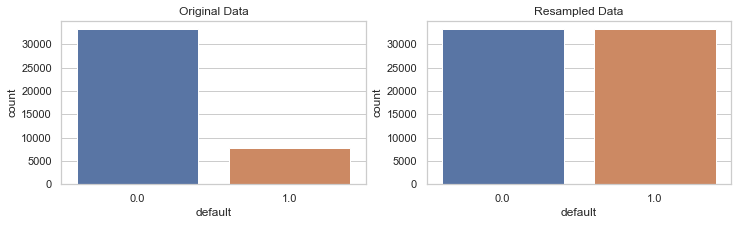

In [237]:
plt.figure(figsize = (12, 3))
plt.subplot(1, 2, 1)
sns.countplot(ytrain)
plt.title("Original Data")

plt.subplot(1, 2, 2)
sns.countplot(ytrain_new)
plt.title("Resampled Data")

plt.show()

* We can see that we have balanced the data.

In [238]:
log_reg2 = LogisticRegression(max_iter=1000)

log_reg2.fit(xtrain_new, ytrain_new)

LogisticRegression(max_iter=1000)

In [239]:
report_(ytrain_new, log_reg2.predict(xtrain_new))

Accuracy =  0.6751992780869304
Recall =  0.7057301849902241
Precision =  0.6651169383416017
F1_score =  0.6848219497956801


In [240]:
report_(ytest, log_reg2.predict(xtest))

Accuracy =  0.6805393868839736
Recall =  0.6234021632251721
Precision =  0.1788939051918736
F1_score =  0.27800920850690636


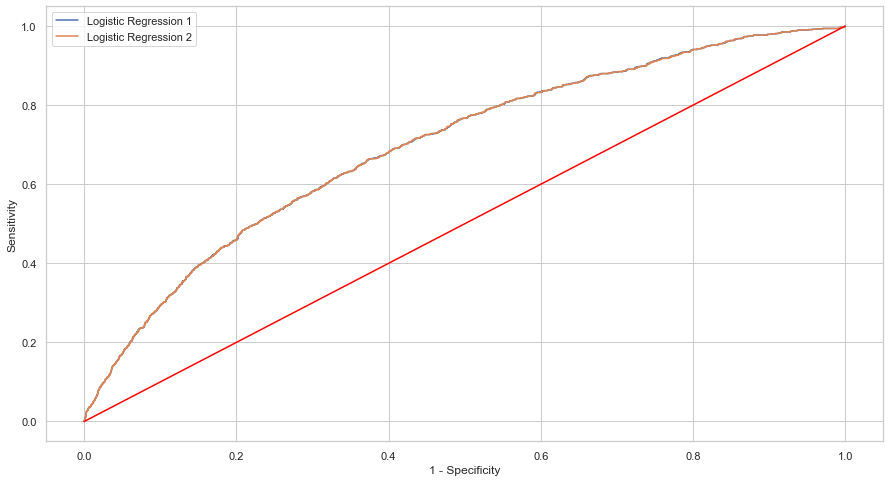

In [241]:
yscore_lr2 = cross_val_predict(log_reg2, xtest, ytest, cv = 3, method = 'decision_function')
fpr_lr2, tpr_lr2, th = roc_curve(ytest, yscore_lr2)

plt.plot(fpr_lr1, tpr_lr1, label = "Logistic Regression 1")
plt.legend()
plt.plot(fpr_lr2, tpr_lr2, label = "Logistic Regression 2")
plt.legend()
plt.plot([0, 1], [0, 1], color = 'red')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()

Seems like model is over fitting.

## 7.2 Using Decision Tree:

In [242]:
dtc1 = DecisionTreeClassifier()
dtc1.fit(xtrain_new, ytrain_new)

report_(ytrain_new, dtc1.predict(xtrain_new))

Accuracy =  1.0
Recall =  1.0
Precision =  1.0
F1_score =  1.0


In [243]:
report_(ytest, dtc1.predict(xtest))

Accuracy =  0.7374854481955763
Recall =  0.336283185840708
Precision =  0.14412136536030343
F1_score =  0.2017699115044248


* We can see that Decision Tree is overfitting. And it's not doing any good than logistic regression.

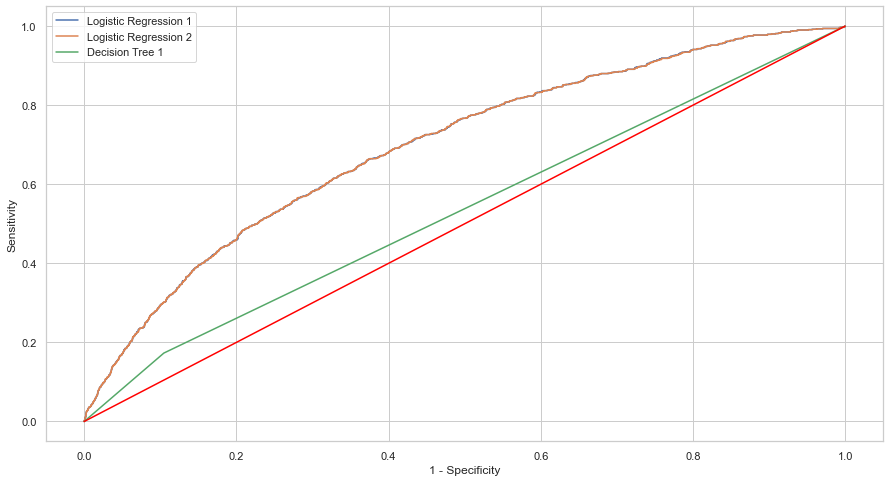

In [244]:
yscore_dtc1 = cross_val_predict(dtc1, xtest, ytest, cv = 3, method = 'predict_proba')
fpr_dtc1, tpr_dtc1, th = roc_curve(ytest, yscore_dtc1[:, 1])

#log reg1
plt.plot(fpr_lr1, tpr_lr1, label = "Logistic Regression 1")
plt.legend()

#log reg2
plt.plot(fpr_lr2, tpr_lr2, label = "Logistic Regression 2")
plt.legend()

# decision tree1
plt.plot(fpr_dtc1, tpr_dtc1, label = "Decision Tree 1")
plt.legend()
plt.plot([0, 1], [0, 1], color = 'red')

plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()

## 7.3 Using Random Forrest:


In [245]:
rfc1 = RandomForestClassifier()

rfc1.fit(xtrain_new, ytrain_new)

RandomForestClassifier()

In [246]:
report_(ytrain_new, rfc1.predict(xtrain_new))

Accuracy =  1.0
Recall =  1.0
Precision =  1.0
F1_score =  1.0


In [247]:
report_(ytest, rfc1.predict(xtest))

Accuracy =  0.8715560729530462
Recall =  0.176007866273353
Precision =  0.26917293233082706
F1_score =  0.21284185493460167


* Again Random Forrest is also over fitting.

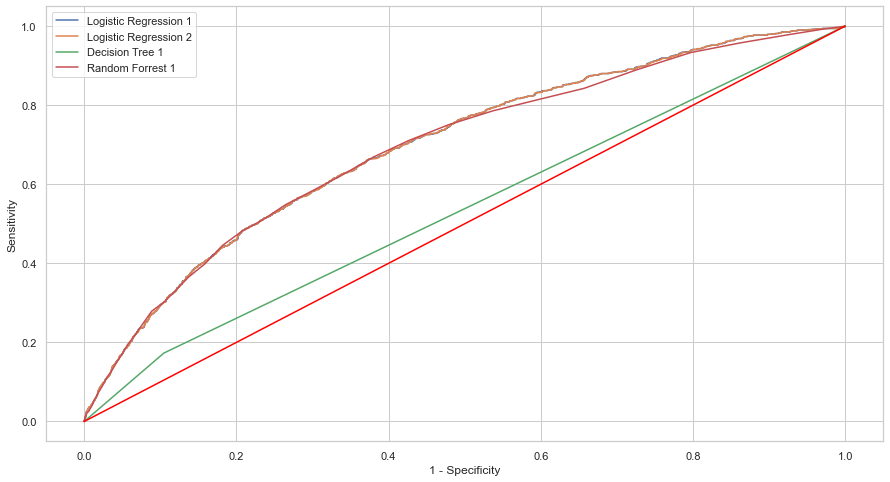

In [248]:
yscore_rfc1 = cross_val_predict(rfc1, xtest, ytest, cv = 3, method = 'predict_proba')
fpr_rfc1, tpr_rfc1, th = roc_curve(ytest, yscore_rfc1[:, 1])

#log reg1
plt.plot(fpr_lr1, tpr_lr1, label = "Logistic Regression 1")
plt.legend()

#log reg2
plt.plot(fpr_lr2, tpr_lr2, label = "Logistic Regression 2")
plt.legend()

# decision tree1
plt.plot(fpr_dtc1, tpr_dtc1, label = "Decision Tree 1")
plt.legend()

# Random Forrest1
plt.plot(fpr_rfc1, tpr_rfc1, label = "Random Forrest 1")
plt.legend()

plt.plot([0, 1], [0, 1], color = 'red')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()

## 7.4 Trying XGBoost:

In [249]:
xgbc1 = XGBClassifier()
xgbc1.fit(xtrain_new, ytrain_new)

[11:18:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [250]:
report_(ytrain_new, xgbc1.predict(xtrain_new))

Accuracy =  0.9152504135960294
Recall =  0.8423221537073244
Precision =  0.9861600225383856
F1_score =  0.9085835726221183


In [251]:
report_(ytest, xgbc1.predict(xtest))

Accuracy =  0.8827124563445867
Recall =  0.16224188790560473
Precision =  0.3160919540229885
F1_score =  0.21442495126705655


[11:18:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


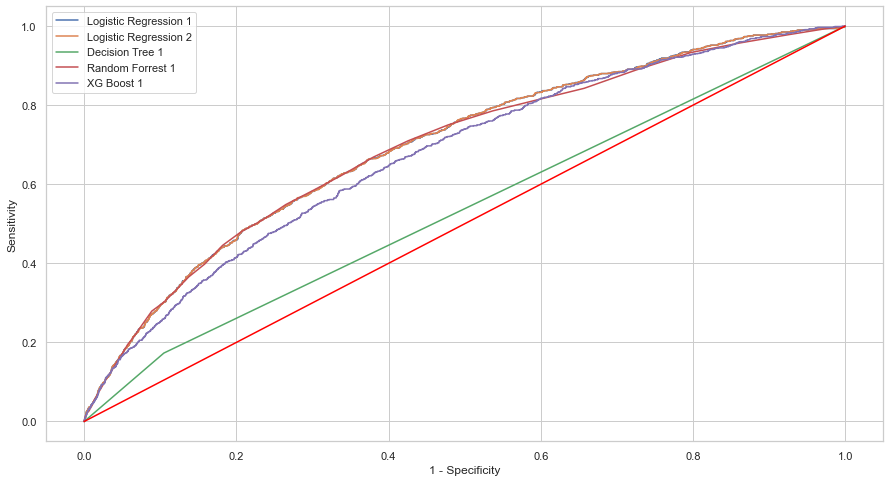

In [252]:
yscore_xgbc1 = cross_val_predict(xgbc1, xtest, ytest, cv = 3, method = 'predict_proba')
fpr_xgbc1, tpr_xgbc1, th = roc_curve(ytest, yscore_xgbc1[:, 1])

#log reg1
plt.plot(fpr_lr1, tpr_lr1, label = "Logistic Regression 1")
plt.legend()

#log reg2
plt.plot(fpr_lr2, tpr_lr2, label = "Logistic Regression 2")
plt.legend()

# decision tree1
plt.plot(fpr_dtc1, tpr_dtc1, label = "Decision Tree 1")
plt.legend()

# Random Forrest1
plt.plot(fpr_rfc1, tpr_rfc1, label = "Random Forrest 1")
plt.legend()

# XG Boost1
plt.plot(fpr_xgbc1, tpr_xgbc1, label = "XG Boost 1")
plt.legend()

plt.plot([0, 1], [0, 1], color = 'red')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()

We can see XGBoost Classifier is doing a little better than others.

## 7.6 SGDClassifier:

In [253]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(alpha = 0.01)

sgd.fit(xtrain_new, ytrain_new)

SGDClassifier(alpha=0.01)

In [254]:
report_(ytrain_new, sgd.predict(xtrain_new))

Accuracy =  0.6599037449240487
Recall =  0.7090088735148142
Precision =  0.6456039441248973
F1_score =  0.6758225216830336


In [255]:
report_(ytest, sgd.predict(xtest))

Accuracy =  0.5864377182770664
Recall =  0.7187807276302851
Precision =  0.155267629566695
F1_score =  0.2553711790393013


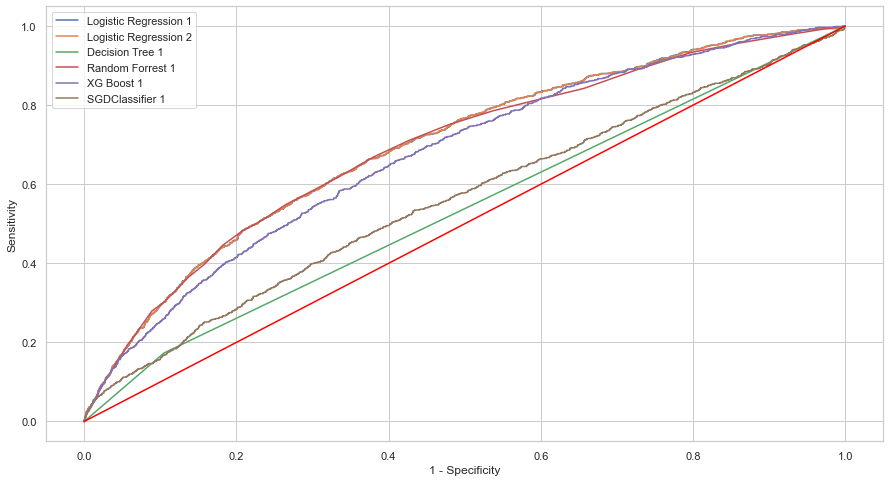

In [256]:
yscore_sgd = cross_val_predict(sgd, xtest, ytest, cv = 3, method = 'decision_function')
fpr_sgd, tpr_sgd, th = roc_curve(ytest, yscore_sgd)

#log reg1
plt.plot(fpr_lr1, tpr_lr1, label = "Logistic Regression 1")
plt.legend()

#log reg2
plt.plot(fpr_lr2, tpr_lr2, label = "Logistic Regression 2")
plt.legend()

# decision tree1
plt.plot(fpr_dtc1, tpr_dtc1, label = "Decision Tree 1")
plt.legend()

# Random Forrest1
plt.plot(fpr_rfc1, tpr_rfc1, label = "Random Forrest 1")
plt.legend()

# XG Boost1
plt.plot(fpr_xgbc1, tpr_xgbc1, label = "XG Boost 1")
plt.legend()

# SGDClassifier 1
plt.plot(fpr_sgd, tpr_sgd, label = "SGDClassifier 1")
plt.legend()

plt.plot([0, 1], [0, 1], color = 'red')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()

* SGD Classifier is better model than all others, but it's very minute difference.

## 7.7 Hyperparameter tuning for Logistic Regression:

In [257]:
from sklearn.model_selection import GridSearchCV

ef __init__(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

In [258]:
p = [{'penalty': ['l2', 'l1', 'elasticnet'],
      'max_iter': [50, 100, 150, 500, 700, 1000]}]

lg = GridSearchCV(LogisticRegression(), p)
lg.fit(xtrain_new, ytrain_new)

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'max_iter': [50, 100, 150, 500, 700, 1000],
                          'penalty': ['l2', 'l1', 'elasticnet']}])

In [259]:
report_(ytrain_new, lg.predict(xtrain_new))

Accuracy =  0.6743420063167394
Recall =  0.7040156414498421
Precision =  0.6645749332727583
F1_score =  0.683726976615106


In [260]:
lg.best_params_

{'max_iter': 50, 'penalty': 'l2'}

In [262]:
report_(ytest, lg.predict(xtest))

Accuracy =  0.633779588668995
Recall =  0.6774827925270404
Precision =  0.16658607350096713
F1_score =  0.26741703861828064


In [264]:
log_reg3 = LogisticRegression(max_iter = 50, penalty = 'l2')
log_reg3.fit(xtrain_new, ytrain_new)


LogisticRegression(max_iter=50)

In [265]:
report_(ytrain_new, log_reg3.predict(xtrain_new))

Accuracy =  0.6743420063167394
Recall =  0.7040156414498421
Precision =  0.6645749332727583
F1_score =  0.683726976615106


In [266]:
report_(ytest, log_reg3.predict(xtest))

Accuracy =  0.633779588668995
Recall =  0.6774827925270404
Precision =  0.16658607350096713
F1_score =  0.26741703861828064


In [267]:
log_reg3.coef_

array([[ 0.0810945 , -0.0026111 , -0.02895645, -0.28808678,  0.35173886,
        -0.10079074,  0.25865917, -0.10326658,  0.22015059, -0.03287081,
        -0.04865473,  0.02715446, -0.10846288, -0.19914362, -0.15892518,
        -0.0591407 ,  0.08912811, -0.04289661, -0.03126958,  0.19436305,
        -0.02027099, -0.04053769, -0.01484752,  0.00347716,  0.00183554,
         0.02066057,  0.01850565,  0.02603821,  0.01897306,  0.01754673,
         0.0114934 , -0.21884575, -0.09622609,  0.04765429,  0.08106403,
         0.14387889,  0.01562445,  0.0371424 , -0.04053769, -0.01484752,
         0.02066057,  0.00183554,  0.01850565,  0.02603821,  0.01897306,
         0.01760275,  0.00347716,  0.05212391,  0.0114934 , -0.0025037 ,
        -0.02968824, -0.02184524,  0.06186779,  0.07816765,  0.12487682,
         0.14107112,  0.17078035,  0.19277778,  0.22855993,  0.23080636,
         0.24239837,  0.24819932,  0.3002788 ,  0.27688791,  0.25954356,
         0.27378333,  0.25475366,  0.24541148,  0.2

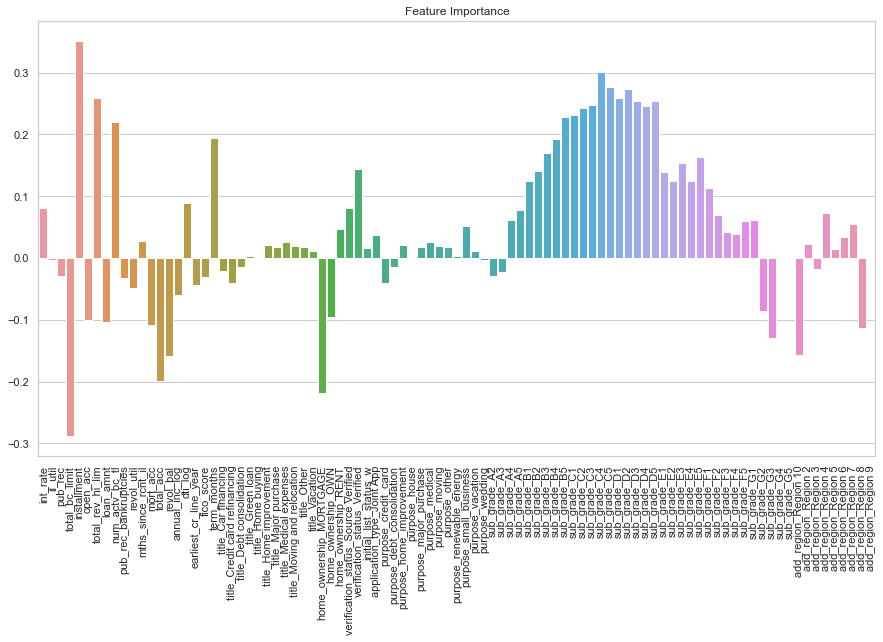

In [269]:
sns.barplot(x = xtrain_new.columns, y = log_reg3.coef_[0])
plt.xticks(rotation = 90)
plt.title("Feature Importance")
plt.show()

* Total bank card limit and installment play a major role in predicting if some one is going to default or not, which means that a person with higher installment is more likely to default which can be quite obvious that that applicant is not able to manage his income in order to pay back the loan.
* Similarly a person having higher bank card limit is less likely to default.
* Home owenership also plays a major role in predicting default.
* Total credit accounts, which as we stated in EDA, means that person is getting thismany number of accounts because he/she was in good terms with the previous creditor.
* It is interesting to see that some regions have major play in default, which means that company have to take region into consideration while giving out loan.